# BO with AX.DEV tutorial

# Overview

1. **Gaussian Peak Function**:
   - The `gaussian_peak` function represents a 2D Gaussian distribution, centered at coordinates (0.2, 0.1). The standard deviation for both dimensions is set to 0.1, resulting in a peak centered at this point with a smooth, bell-shaped decline.
   - This function serves as the objective to be optimized by Bayesian optimization, simulating a scenario where we seek to find the peak value (maximum).

2. **Grid Sweep**:
   - A grid of points is generated from -1 to 1 for both `x` and `y` dimensions. The function is evaluated at each point in this grid to create a 2D representation of the objective surface.
   - This grid-based evaluation allows visualization of the entire parameter space, providing a baseline to compare against the Bayesian optimization process. It helps illustrate the quality of the optimization results.

3. **Bayesian Optimization Setup**:
   - The Bayesian optimization is implemented using the Ax framework, which allows for flexible experimentation with different optimization strategies.
   - **Generation Strategy**:
     - A **Sobol** sampling strategy is employed for initial exploration of the parameter space (`num_initial_samples` points). Sobol sequences are effective for sampling evenly across the parameter space, ensuring a good initial understanding of the landscape.
     - After Sobol sampling, a **Gaussian Process with Expected Improvement (GPEI)** model is used to refine the search for the maximum. The GPEI model leverages a surrogate model (Gaussian Process) to balance exploration and exploitation, optimizing the objective until convergence or exhaustion of allowed trials (`num_trials=-1` means it continues indefinitely until another stopping criterion is met).
     - The generation strategy helps control how the initial exploration and subsequent exploitation phases are managed.
   - **Objective Setup**:
     - The objective is defined as maximizing `z`, which represents the value of the Gaussian peak given the inputs `x` and `y`. The experiment is designed with two parameters (`x` and `y`), both ranging from -1 to 1.

4. **Optimization Loop**:
   - The optimization loop iterates for up to `num_bo_samples` times, or until a convergence criterion is met.
   - **Exploitation vs. Exploration**:
     - In each iteration, a decision is made on whether to exploit the known high-performing areas (`GPEI`) or to explore less certain regions (`qNIPV` - Negative Integrated Posterior Variance). This is determined based on the ratio defined by `exploit_ratio`.
     - **Exploitation** (`GPEI`): Focuses on sampling points that are expected to yield the highest improvement based on the current surrogate model.
     - **Exploration** (`qNIPV`): Samples points to reduce uncertainty in the model, helping to improve the quality of the surrogate model and prevent getting stuck in local optima.
     - The balance between exploitation and exploration is key to efficiently finding the global optimum while avoiding local traps.
   - **Convergence Check**:
     - After each iteration, the improvement in the objective function is checked. If the improvement falls below a defined threshold (`epsilon`) for a specified number of consecutive iterations (`patience`), the optimization is stopped early. This prevents unnecessary computation when further significant improvements are unlikely.
     - Refitting the GP model every `refit_every` iterations helps maintain model accuracy without excessive computational cost.

5. **Normalization and Standardization**:
   - **Normalization**: Inputs (`x` and `y`) are normalized to ensure they fall within a consistent range. This helps the optimization algorithm treat all inputs equally, regardless of their original scale, thereby improving numerical stability and the performance of the Gaussian Process model.
   - **Standardization**: Outputs (`z`) are standardized to have zero mean and unit variance. This ensures the objective values are easier for the model to learn and improves training efficiency. Standardizing outputs is particularly important for Gaussian Process models, which are sensitive to the scale of the data.

6. **Plotting**:
   - The visualization consists of two subplots:
     - **Grid Sweep Plot**: The first subplot shows the objective function evaluated over a dense grid of points. This gives a clear picture of the Gaussian peak and serves as the reference for assessing the performance of the optimizer.
     - **Bayesian Optimization Process Plot**: The second subplot illustrates the points sampled by the Bayesian optimization process. The sampled points are shown as black circles overlaid on a color map created via `scipy.interpolate.griddata`. This plot helps visualize how the optimizer explores and exploits the parameter space to converge on the peak of the Gaussian.
   - The distinction between the grid-based visualization and the Bayesian optimization plot helps in understanding the efficiency of the optimizer compared to a brute-force approach of evaluating all points in the parameter space.

# Simple Ax.dev BO


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from ax import optimize
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition import qNegIntegratedPosteriorVariance
import random
from typing import Tuple
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from ax.utils.common.logger import get_logger

logger = get_logger(__name__)

def bayesian_optimizer(num_initial_samples: int = 10, num_bo_samples: int = 100, epsilon: float = 1e-3, patience: int = 15, refit_every: int = 10, exploit_ratio: float = 0.9, seed: int = 1):
    """
    Bayesian optimization function that yields new points to sample.

    Args:
        num_initial_samples (int): Number of initial Sobol samples for exploration. These samples provide a broad understanding of the parameter space.
        num_bo_samples (int): Maximum number of Bayesian optimization samples to be taken after the initial exploration.
        epsilon (float): Convergence threshold. If the improvement in the objective function value is less than this threshold, it is considered as no improvement.
        patience (int): Number of iterations without improvement to allow before stopping early. Helps prevent unnecessary computation if the model is no longer improving.
        refit_every (int): Number of iterations after which the GP model is refit. Refitting frequently can improve model accuracy but is computationally expensive.
        exploit_ratio (float): Proportion of times exploitation (GPEI) is used compared to exploration (qNIPV). A higher value favors exploitation over exploration.
        seed (int): Random seed for reproducibility of the optimization process.
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    # Setting up the Bayesian optimizer using Ax with a custom generation strategy.
    # The generation strategy defines how initial exploration (using Sobol) and subsequent optimization (using GPEI) are conducted.
    generation_strategy = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
            GenerationStep(model=Models.GPEI, num_trials=-1),
        ]
    )

    ax_client = AxClient(generation_strategy=generation_strategy)
    ax_client.create_experiment(
        name="2d_gaussian_peak_optimization",
        parameters=[
            {"name": "x", "type": "range", "bounds": [-1.0, 1.0]},
            {"name": "y", "type": "range", "bounds": [-1.0, 1.0]},
        ],
        objective_name="z",
        minimize=False,  # Set True if you want to minimize the objective
    )

    # Lists to store sampled points and their objective values.
    z_samples = []
    x_samples = []
    y_samples = []

    # Initial exploration with Sobol sampling.
    for _ in range(num_initial_samples):
        params, trial_index = ax_client.get_next_trial()
        x_sample, y_sample = params['x'], params['y']
        z = np.exp(-((x_sample - 0.2) ** 2 + (y_sample - 0.1) ** 2) / (2 * 0.1 ** 2))
        x_samples.append(x_sample)
        y_samples.append(y_sample)
        z_samples.append(z)
        ax_client.complete_trial(trial_index=trial_index, raw_data=z)
        yield x_sample, y_sample, z

    # Convert inputs to tensors for model training.
    x_samples_tensor = torch.tensor(x_samples).double().reshape(-1, 1)
    y_samples_tensor = torch.tensor(y_samples).double().reshape(-1, 1)
    z_samples_tensor = torch.tensor(z_samples).double().flatten()
    x_y_samples_tensor = torch.cat([x_samples_tensor, y_samples_tensor], dim=1)

    # Define and fit the GP model.
    gp_model = SingleTaskGP(x_y_samples_tensor, z_samples_tensor.unsqueeze(-1))
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)

    # Bayesian optimization loop with convergence criteria.
    best_value = None
    no_improvement_counter = 0

    for i in range(num_bo_samples):
        # Randomly decide whether to use exploitation (GPEI) or exploration (qNIPV)
        rand_value = random.random()
        if rand_value < exploit_ratio:
            # Exploitation with GPEI
            logger.info("Using GPEI for exploitation")
            ax_client.generation_strategy._steps[-1].model = Models.GPEI
        else:
            # Exploration with qNIPV
            logger.info("Using qNIPV for exploration")
            ax_client.generation_strategy._steps[-1].model = Models.BOTORCH_MODULAR
            ax_client.generation_strategy._steps[-1].model_kwargs = {
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options": {"mc_points": 500},
            }

        params, trial_index = ax_client.get_next_trial()
        x_sample, y_sample = params['x'], params['y']
        z = np.exp(-((x_sample - 0.2) ** 2 + (y_sample - 0.1) ** 2) / (2 * 0.1 ** 2))
        x_samples.append(x_sample)
        y_samples.append(y_sample)
        z_samples.append(z)
        ax_client.complete_trial(trial_index=trial_index, raw_data=z)
        yield x_sample, y_sample, z

        # Add new sample to training data
        x_samples_tensor = torch.tensor(x_samples).double().reshape(-1, 1)
        y_samples_tensor = torch.tensor(y_samples).double().reshape(-1, 1)
        z_samples_tensor = torch.tensor(z_samples).double().flatten()
        x_y_samples_tensor = torch.cat([x_samples_tensor, y_samples_tensor], dim=1)

        # Refit the GP model only every `refit_every` iterations to reduce computational overhead.
        # Refitting every few iterations helps maintain model accuracy without excessive computational cost.
        if i % refit_every == 0 or i == num_bo_samples - 1:
            gp_model.set_train_data(x_y_samples_tensor, z_samples_tensor.unsqueeze(-1), strict=False)
            fit_gpytorch_model(mll)

        # Check for convergence based on improvement only during exploitation.
        if rand_value < exploit_ratio:  # Only check for convergence during exploitation
            if best_value is None or z > best_value + epsilon:
                best_value = z
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1

        # Stop early if no improvement for a number of iterations.
        if no_improvement_counter >= patience:
            print(f"Stopping early after {i + 1} iterations due to lack of improvement.")
            break


# Create interpolation for the scatter plot using scipy's griddata.
x_interp, y_interp = np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)
x_interp_grid, y_interp_grid = np.meshgrid(x_interp, y_interp)
z_interp = griddata((x_samples, y_samples), z_samples, (x_interp_grid, y_interp_grid), method='cubic')

# Plotting the grid sweep version.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pcolormesh for grid sweep version.
c1 = ax[0].pcolormesh(x_grid, y_grid, z_grid, shading='auto', cmap='viridis')
fig.colorbar(c1, ax=ax[0])
ax[0].set_title("Grid Sweep (51x51 points)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

# Scatter plot over griddata interpolation.
c2 = ax[1].pcolormesh(x_interp_grid, y_interp_grid, z_interp, shading='auto', cmap='viridis')
fig.colorbar(c2, ax=ax[1])
ax[1].scatter(x_samples, y_samples, edgecolor='black', facecolor='none', s=50)  # Black circles with no facevalues
ax[1].set_title("Scatterplot with Interpolation")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

plt.tight_layout()
plt.show()

# Ax.dev with full features
- Adding in exploration
- scalarizing inputs 
- converting to utility function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from ax import optimize
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition import qNegIntegratedPosteriorVariance
import random
from typing import Tuple
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from ax.utils.common.logger import get_logger

logger = get_logger(__name__)
from gpytorch.settings import max_cg_iterations


def bayesian_optimizer(num_initial_samples: int = 10, num_bo_samples: int = 100, epsilon: float = 1e-3, patience: int = 15, refit_every: int = 10, exploit_ratio: float = 0.9, seed: int = 1):
    """
    Bayesian optimization function that yields new points to sample.

    Args:
        num_initial_samples (int): Number of initial Sobol samples for exploration.
        num_bo_samples (int): Maximum number of Bayesian optimization samples to be taken after the initial exploration.
        epsilon (float): Convergence threshold.
        patience (int): Number of iterations without improvement to allow before stopping early.
        refit_every (int): Number of iterations after which the GP model is refit.
        exploit_ratio (float): Proportion of times exploitation (GPEI) is used compared to exploration (qNIPV).
        seed (int): Random seed for reproducibility.
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    # Setting up the Bayesian optimizer using Ax with a custom generation strategy.
    generation_strategy = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
            GenerationStep(model=Models.GPEI, num_trials=-1),
        ]
    )

    ax_client = AxClient(generation_strategy=generation_strategy)
    ax_client.create_experiment(
        name="2d_gaussian_peak_optimization",
        parameters=[
            {"name": "x", "type": "range", "bounds": [-1.0, 1.0]},
            {"name": "y", "type": "range", "bounds": [-1.0, 1.0]},
        ],
        objective_name="z",
        minimize=False,  # Set True if you want to minimize the objective
    )

    # Lists to store sampled points and their objective values.
    z_samples = []
    x_samples = []
    y_samples = []

    # Initial exploration with Sobol sampling.
    for _ in range(num_initial_samples):
        params, trial_index = ax_client.get_next_trial()
        x_sample, y_sample = params['x'], params['y']
        z = np.exp(-((x_sample - 0.2) ** 2 + (y_sample - 0.1) ** 2) / (2 * 0.1 ** 2))
        x_samples.append(x_sample)
        y_samples.append(y_sample)
        z_samples.append(z)
        ax_client.complete_trial(trial_index=trial_index, raw_data=z)
        yield x_sample, y_sample, z

    # Define and fit the GP model.
    x_y_samples_tensor = torch.tensor(np.column_stack([x_samples, y_samples])).double()
    z_samples_tensor = torch.tensor(z_samples).double().unsqueeze(-1)
    gp_model = SingleTaskGP(x_y_samples_tensor, z_samples_tensor)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)

    # Bayesian optimization loop with convergence criteria.
    best_value = None
    no_improvement_counter = 0

    for i in range(num_bo_samples):
        # Randomly decide whether to use exploitation (GPEI) or exploration (qNIPV)
        rand_value = random.random()
        if rand_value < exploit_ratio:
            logger.info("Using GPEI for exploitation")
            ax_client.generation_strategy._steps[-1].model = Models.GPEI
        else:
            logger.info("Using qNIPV for exploration")
            ax_client.generation_strategy._steps[-1].model = Models.BOTORCH_MODULAR
            ax_client.generation_strategy._steps[-1].model_kwargs = {
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options": {"mc_points": 10},
            }

        params, trial_index = ax_client.get_next_trial()
        x_sample, y_sample = params['x'], params['y']
        z = np.exp(-((x_sample - 0.2) ** 2 + (y_sample - 0.1) ** 2) / (2 * 0.1 ** 2))
        x_samples.append(x_sample)
        y_samples.append(y_sample)
        z_samples.append(z)
        ax_client.complete_trial(trial_index=trial_index, raw_data=z)
        yield x_sample, y_sample, z

        x_y_samples_tensor = torch.tensor(np.column_stack([x_samples, y_samples])).double()
        z_samples_tensor = torch.tensor(z_samples).double().unsqueeze(-1)

        if i % refit_every == 0 or i == num_bo_samples - 1:
            gp_model.set_train_data(x_y_samples_tensor, z_samples_tensor, strict=False)
            with max_cg_iterations(50):  # Use fewer iterations for solving GP equations
                fit_gpytorch_model(mll)
                
        if rand_value < exploit_ratio:
            if best_value is None or z > best_value + epsilon:
                best_value = z
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1

        if no_improvement_counter >= patience:
            print(f"Stopping early after {i + 1} iterations due to lack of improvement.")
            break


## Example use case with bayesian_optimizer()

In [ ]:
# Use the Bayesian optimizer to get new points.
x_samples, y_samples, z_samples = [], [], []
for x_sample, y_sample, z in bayesian_optimizer():
    x_samples.append(x_sample)
    y_samples.append(y_sample)
    z_samples.append(z)

In [ ]:
# Create a grid sweep version (51 x 51 points).
x = np.linspace(-1, 1, 51)
y = np.linspace(-1, 1, 51)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = np.exp(-((x_grid - 0.2) ** 2 + (y_grid - 0.1) ** 2) / (2 * 0.1 ** 2))



# Create interpolation for the scatter plot using scipy's griddata.
x_interp = np.linspace(-1, 1, 50)
y_interp = np.linspace(-1, 1, 50)
x_interp_grid, y_interp_grid = np.meshgrid(x_interp, y_interp)
z_interp = griddata((x_samples, y_samples), z_samples, (x_interp_grid, y_interp_grid), method='linear')

# Plotting the grid sweep version.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pcolormesh for grid sweep version.
c1 = ax[0].pcolormesh(x_grid, y_grid, z_grid, shading='auto', cmap='viridis')
ax[0].set_title("Grid Sweep (Gaussian Peak)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
fig.colorbar(c1, ax=ax[0])

# Scatter plot with interpolation for Bayesian optimization samples.
c2 = ax[1].pcolormesh(x_interp_grid, y_interp_grid, z_interp, shading='auto', cmap='viridis')
ax[1].scatter(x_samples, y_samples, edgecolor='black', facecolor='none')
ax[1].set_title("Bayesian Optimization (Gaussian Peak)")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
fig.colorbar(c2, ax=ax[1])

plt.tight_layout()
plt.show()

# Async + batch

In [27]:
import asyncio
import numpy as np
import torch
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.acquisition import qNegIntegratedPosteriorVariance
from botorch.models.gp_regression import SingleTaskGP
from ax.service.utils.instantiation import ObjectiveProperties


class ZReader:
    """Fake response for testing purposes."""
    def __init__(self, centers, sigma=0.1, n_samples=1):
        """
        Initialize the Gaussian response surface.

        Args:
            centers (list): Centers of the Gaussian for each parameter.
            sigma (float): Standard deviation of the Gaussian.
            n_samples (int): Number of samples to compute mean and SEM.
        """
        self.centers = np.array(centers)
        self.sigma = sigma
        self.n_samples = n_samples

    def read(self, params):
        """
        Compute the Gaussian response and optionally SEM.

        Args:
            params (list): List of parameter values.

        Returns:
            tuple: (mean, sem) if n_samples > 1 else (z, 0.0).
        """
        params = np.array(params)
        z = np.exp(-np.sum((params - self.centers) ** 2) / (2 * self.sigma ** 2))
        if self.n_samples > 1:
            noisy_z = [z + np.random.normal(0, self.sigma) for _ in range(self.n_samples)]
            mean_z = np.mean(noisy_z)
            sem_z = np.std(noisy_z) / np.sqrt(self.n_samples)
            return mean_z, sem_z
        return z, 0.0


async def get_next_batch_async(ax_client, batch_size):
    """Fetch the next batch of trials asynchronously."""
    loop = asyncio.get_event_loop()
    return await asyncio.gather(
        *[loop.run_in_executor(None, ax_client.get_next_trial) for _ in range(batch_size)]
    )


async def complete_trial_async(ax_client, trial_index, result):
    """Complete a trial asynchronously."""
    loop = asyncio.get_event_loop()
    return await loop.run_in_executor(None, ax_client.complete_trial, trial_index, result)


async def bayesian_optimizer_iterator(
    z_reader,
    param_names,
    param_bounds,
    num_initial_samples=10,
    num_bo_samples=20,
    batch_size=1,
    explore_ratio=0.1,
    async_mode=True
):
    """
    Bayesian optimizer iterator that can run asynchronously or synchronously depending on `async_mode`.

    Args:
        z_reader: An object with a `.read()` method to fetch the latest objective value.
        param_names (list): Names of the input parameters.
        param_bounds (list of tuples): Bounds for each parameter (min, max).
        num_initial_samples (int): Number of initial Sobol samples.
        num_bo_samples (int): Total number of Bayesian optimization samples.
        batch_size (int): Number of trials generated in each batch.
        explore_ratio (float): Probability of using qNIPV for exploration.
        async_mode (bool): If True, use asynchronous operations, else synchronous.

    Yields:
        dict: A dictionary of parameter values to evaluate.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generation_strategy = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
            GenerationStep(model=Models.GPEI, num_trials=-1, max_parallelism=batch_size),
        ]
    )
    ax_client = AxClient(generation_strategy=generation_strategy, torch_device=device)
    ax_client.create_experiment(
        name="modular_iterator_optimization",
        parameters=[
            {"name": name, "type": "range", "bounds": bounds}
            for name, bounds in zip(param_names, param_bounds)
        ],
        objectives={"z": ObjectiveProperties(minimize=False)},
        parameter_constraints=[],
        tracking_metric_names=[],
    )

    # Helper functions to abstract async/sync behavior
    async def get_next_batch(ax_client, b_size):
        if async_mode:
            return await get_next_batch_async(ax_client, b_size)
        else:
            return [ax_client.get_next_trial() for _ in range(b_size)]

    async def complete_trial(ax_client, t_index, res):
        if async_mode:
            return await complete_trial_async(ax_client, t_index, res)
        else:
            return ax_client.complete_trial(t_index, res)

    # Initial Sobol samples
    for _ in range(num_initial_samples):
        trials = await get_next_batch(ax_client, 1)
        params, trial_index = trials[0]
        yield params
        z_mean, z_sem = z_reader.read([params[name] for name in param_names])
        await complete_trial(ax_client, trial_index, {"z": (z_mean, z_sem)})

    # Bayesian optimization loop
    remaining_samples = num_bo_samples
    while remaining_samples > 0:
        current_batch_size = min(batch_size, remaining_samples)

        # Decide between exploration (qNIPV) and exploitation (GPEI)
        explore = np.random.rand() < explore_ratio
        if explore:
            print("Using qNIPV (Exploration)")
            ax_client.generation_strategy._steps[-1].model = Models.BOTORCH_MODULAR
            ax_client.generation_strategy._steps[-1].model_kwargs = {
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options": {"mc_points": 50},
            }
        else:
            print("Using GPEI (Exploitation)")
            ax_client.generation_strategy._steps[-1].model = Models.GPEI
            ax_client.generation_strategy._steps[-1].model_kwargs = {}

        trials = await get_next_batch(ax_client, current_batch_size)

        for params, trial_index in trials:
            yield params
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            await complete_trial(ax_client, trial_index, {"z": (z_mean, z_sem)})

        remaining_samples -= current_batch_size


def bayesian_optimizer_iterator_sync(
    z_reader,
    param_names,
    param_bounds,
    num_initial_samples=10,
    num_bo_samples=20,
    batch_size=1,
    explore_ratio=0.1
):
    """
    Synchronous Bayesian optimizer iterator.

    Identical logic to bayesian_optimizer_iterator, but runs without async/await.

    Args:
        z_reader: An object with a `.read()` method to fetch the latest objective value.
        param_names (list): Names of the input parameters.
        param_bounds (list of tuples): Bounds for each parameter (min, max).
        num_initial_samples (int): Number of initial Sobol samples.
        num_bo_samples (int): Total number of Bayesian optimization samples.
        batch_size (int): Number of trials generated in each batch.
        explore_ratio (float): Probability of using qNIPV for exploration.

    Yields:
        dict: A dictionary of parameter values to evaluate.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generation_strategy = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
            GenerationStep(model=Models.GPEI, num_trials=-1, max_parallelism=batch_size),
        ]
    )
    ax_client = AxClient(generation_strategy=generation_strategy, torch_device=device)
    ax_client.create_experiment(
        name="modular_iterator_optimization_sync",
        parameters=[
            {"name": name, "type": "range", "bounds": bounds}
            for name, bounds in zip(param_names, param_bounds)
        ],
        objectives={"z": ObjectiveProperties(minimize=False)},
        parameter_constraints=[],
        tracking_metric_names=[],
    )

    # Initial Sobol samples (synchronous)
    for _ in range(num_initial_samples):
        params, trial_index = ax_client.get_next_trial()
        yield params
        z_mean, z_sem = z_reader.read([params[name] for name in param_names])
        ax_client.complete_trial(trial_index, {"z": (z_mean, z_sem)})

    # Bayesian optimization loop (synchronous)
    remaining_samples = num_bo_samples
    while remaining_samples > 0:
        current_batch_size = min(batch_size, remaining_samples)

        # Decide between exploration (qNIPV) and exploitation (GPEI)
        explore = np.random.rand() < explore_ratio
        if explore:
            print("Using qNIPV (Exploration)")
            ax_client.generation_strategy._steps[-1].model = Models.BOTORCH_MODULAR
            ax_client.generation_strategy._steps[-1].model_kwargs = {
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options": {"mc_points": 50},
            }
        else:
            print("Using GPEI (Exploitation)")
            ax_client.generation_strategy._steps[-1].model = Models.GPEI
            ax_client.generation_strategy._steps[-1].model_kwargs = {}

        # Generate trials synchronously
        for _ in range(current_batch_size):
            params, trial_index = ax_client.get_next_trial()
            yield params
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            ax_client.complete_trial(trial_index, {"z": (z_mean, z_sem)})

        remaining_samples -= current_batch_size

param_names = ["a", "b"]  # Parameter names
param_bounds = [[-1.0, 1.0], [-1.0, 1.0]]  # Parameter bounds as lists

z_reader = ZReader(centers=[0.2, 0.1], sigma=0.1, n_samples=1)  # Create a fake response

# Lists to store optimization history
suggested_params = []
observed_z = []
best_result = {"params": None, "value": float("-inf")}  # Initialize with worst possible value

# Asynchronously:
async for params in bayesian_optimizer_iterator(z_reader, param_names, param_bounds, num_initial_samples=20, num_bo_samples=30, batch_size=2, async_mode=True):
    z_mean, z_sem = z_reader.read([params[name] for name in param_names])
    suggested_params.append(params)
    observed_z.append(z_mean)
    if z_mean > best_result["value"]:
        best_result = {"params": params, "value": z_mean}


# # Synchronous
# for params in bayesian_optimizer_iterator_sync(
#     z_reader, param_names, param_bounds, num_initial_samples=20, num_bo_samples=20, batch_size=2
# ):
#     z_mean, z_sem = z_reader.read([params[name] for name in param_names])
#     suggested_params.append(params)
#     observed_z.append(z_mean)
#     if z_mean > best_result["value"]:
#         best_result = {"params": params, "value": z_mean}


[INFO 12-13 23:33:05] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:33:05] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:33:05] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:33:05] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='a', parameter_type=FLOAT, range=[-1.0, 1.0]), RangeParameter(name='b', parameter_type=FLOAT, range=[-1.0, 1.0])], parameter_constraints=[]).
[INFO 12-13 23:33:05]

Using GPEI (Exploitation)


[INFO 12-13 23:33:06] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.085082, 'b': 0.180824} using model GPEI.
[INFO 12-13 23:33:06] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.08529, 'b': 0.18096} using model GPEI.
[INFO 12-13 23:33:06] ax.service.ax_client: Completed trial 21 with data: {'z': (0.373198, 0.0)}.
[INFO 12-13 23:33:06] ax.service.ax_client: Completed trial 20 with data: {'z': (0.372717, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:33:08] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.209049, 'b': 0.236178} using model GPEI.
[INFO 12-13 23:33:08] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.079891, 'b': 0.231736} using model GPEI.
[INFO 12-13 23:33:08] ax.service.ax_client: Completed trial 23 with data: {'z': (0.204123, 0.0)}.
[INFO 12-13 23:33:08] ax.service.ax_client: Completed trial 22 with data: {'z': (0.394034, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:33:09] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.312684, 'b': 0.220209} using model GPEI.
[INFO 12-13 23:33:09] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.168107, 'b': 0.1859} using model GPEI.
[INFO 12-13 23:33:09] ax.service.ax_client: Completed trial 25 with data: {'z': (0.657179, 0.0)}.
[INFO 12-13 23:33:09] ax.service.ax_client: Completed trial 24 with data: {'z': (0.257331, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:33:11] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.16811, 'b': 0.185898} using model GPEI.
[INFO 12-13 23:33:11] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.197374, 'b': 0.16223} using model GPEI.
[INFO 12-13 23:33:11] ax.service.ax_client: Completed trial 27 with data: {'z': (0.823679, 0.0)}.
[INFO 12-13 23:33:11] ax.service.ax_client: Completed trial 26 with data: {'z': (0.657197, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:33:12] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.197368, 'b': 0.162239} using model GPEI.
[INFO 12-13 23:33:12] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.215499, 'b': 0.11841} using model GPEI.
[INFO 12-13 23:33:12] ax.service.ax_client: Completed trial 28 with data: {'z': (0.823633, 0.0)}.
[INFO 12-13 23:33:12] ax.service.ax_client: Completed trial 29 with data: {'z': (0.971458, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:33:13] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.215526, 'b': 0.118462} using model GPEI.
[INFO 12-13 23:33:14] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.210105, 'b': 0.093595} using model GPEI.
[INFO 12-13 23:33:14] ax.service.ax_client: Completed trial 30 with data: {'z': (0.971323, 0.0)}.
[INFO 12-13 23:33:14] ax.service.ax_client: Completed trial 31 with data: {'z': (0.992869, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:33:15] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.505277, 'b': 0.748918} using model GPEI.
[INFO 12-13 23:33:16] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.210157, 'b': 0.093628} using model GPEI.
[INFO 12-13 23:33:16] ax.service.ax_client: Completed trial 33 with data: {'z': (0.992837, 0.0)}.
[INFO 12-13 23:33:16] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:33:17] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.770322, 'b': 0.441213} using model GPEI.
[INFO 12-13 23:33:17] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.224612, 'b': 0.08653} using model GPEI.
[INFO 12-13 23:33:17] ax.service.ax_client: Completed trial 35 with data: {'z': (0.961404, 0.0)}.
[INFO 12-13 23:33:17] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:33:18] ax.service.ax_client: Generated new trial 36 with parameters {'a': -0.093517, 'b': -1.0} using model GPEI.
[INFO 12-13 23:33:19] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.225007, 'b': 0.086232} using model GPEI.
[INFO 12-13 23:33:19] ax.service.ax_client: Completed trial 37 with data: {'z': (0.960075, 0.0)}.
[INFO 12-13 23:33:19] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:33:19] ax.service.ax_client: Generated new trial 38 with parameters {'a': -1.0, 'b': 0.393878} using model GPEI.
[INFO 12-13 23:33:20] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.195914, 'b': 0.097982} using model GPEI.
[INFO 12-13 23:33:20] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:33:20] ax.service.ax_client: Completed trial 39 with data: {'z': (0.998962, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:33:21] ax.service.ax_client: Generated new trial 40 with parameters {'a': -0.212916, 'b': 0.387839} using model GPEI.
[INFO 12-13 23:33:21] ax.service.ax_client: Generated new trial 41 with parameters {'a': -1.0, 'b': -0.503394} using model GPEI.
[INFO 12-13 23:33:21] ax.service.ax_client: Completed trial 40 with data: {'z': (3e-06, 0.0)}.
[INFO 12-13 23:33:21] ax.service.ax_client: Completed trial 41 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:33:22] ax.service.ax_client: Generated new trial 42 with parameters {'a': 0.155653, 'b': 1.0} using model GPEI.
[INFO 12-13 23:33:22] ax.service.ax_client: Generated new trial 43 with parameters {'a': -1.0, 'b': -0.503374} using model GPEI.
[INFO 12-13 23:33:22] ax.service.ax_client: Completed trial 43 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:33:22] ax.service.ax_client: Completed trial 42 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:33:24] ax.service.ax_client: Generated new trial 44 with parameters {'a': -0.583961, 'b': 0.684222} using model GPEI.
[INFO 12-13 23:33:24] ax.service.ax_client: Generated new trial 45 with parameters {'a': 0.155649, 'b': 1.0} using model GPEI.
[INFO 12-13 23:33:24] ax.service.ax_client: Completed trial 44 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:33:24] ax.service.ax_client: Completed trial 45 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:33:25] ax.service.ax_client: Generated new trial 46 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:33:25] ax.service.ax_client: Generated new trial 47 with parameters {'a': -0.616205, 'b': 0.824966} using model GPEI.
[INFO 12-13 23:33:25] ax.service.ax_client: Completed trial 47 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:33:25] ax.service.ax_client: Completed trial 46 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:33:26] ax.service.ax_client: Generated new trial 48 with parameters {'a': 0.331234, 'b': -1.0} using model GPEI.
[INFO 12-13 23:33:26] ax.service.ax_client: Generated new trial 49 with parameters {'a': 0.331142, 'b': -1.0} using model GPEI.
[INFO 12-13 23:33:26] ax.service.ax_client: Completed trial 49 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:33:26] ax.service.ax_client: Completed trial 48 with data: {'z': (0.0, 0.0)}.


In [13]:
best_result

{'params': {'a': 0.19992759298187357, 'b': 0.0994186950527769},
 'value': 0.9999828422362991}

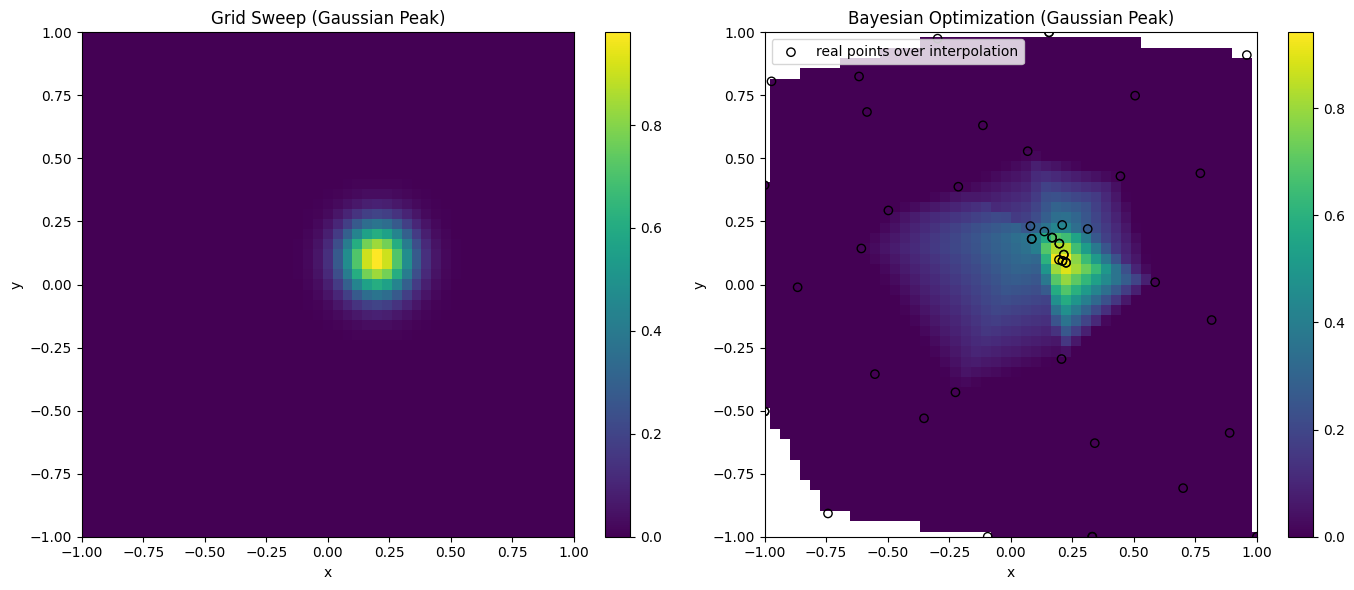

In [28]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np


# Extract x, y, and z for plotting
x_vals = [p["a"] for p in suggested_params]
y_vals = [p["b"] for p in suggested_params]

# Create a grid sweep version (51 x 51 points)
x = np.linspace(-1, 1, 51)
y = np.linspace(-1, 1, 51)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = np.exp(-((x_grid - 0.2) ** 2 + (y_grid - 0.1) ** 2) / (2 * 0.1 ** 2))

# Create interpolation for the scatter plot using scipy's griddata
x_interp = np.linspace(-1, 1, 50)
y_interp = np.linspace(-1, 1, 50)
x_interp_grid, y_interp_grid = np.meshgrid(x_interp, y_interp)
z_interp = griddata((x_vals, y_vals), observed_z, (x_interp_grid, y_interp_grid), method='linear')

# Plotting the grid sweep and Bayesian optimization results
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pcolormesh for grid sweep version
c1 = ax[0].pcolormesh(x_grid, y_grid, z_grid, shading='auto', cmap='viridis')
ax[0].set_title("Grid Sweep (Gaussian Peak)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
fig.colorbar(c1, ax=ax[0])

# Scatter plot with interpolation for Bayesian optimization samples
c2 = ax[1].pcolormesh(x_interp_grid, y_interp_grid, z_interp, shading='auto', cmap='viridis')
ax[1].scatter(x_vals, y_vals, edgecolor='black', facecolor='none', label="real points over interpolation")
ax[1].set_title("Bayesian Optimization (Gaussian Peak)")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].legend()
fig.colorbar(c2, ax=ax[1])

for ax in ax:
    ax.set_ylim(-1,1)
    ax.set_xlim(-1,1)

plt.tight_layout()
plt.show()


# Benchmarking Configs Trial Rates 

[INFO 12-13 23:12:08] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:12:08] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:12:08] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:12:08] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='a', parameter_type=FLOAT, range=[-1.0, 1.0]), RangeParameter(name='b', parameter_type=FLOAT, range=[-1.0, 1.0])], parameter_constraints=[]).
[INFO 12-13 23:12:08]

Using GPEI (Exploitation)


[INFO 12-13 23:12:09] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.07761, 'b': 0.21962} using model GPEI.
[INFO 12-13 23:12:09] ax.service.ax_client: Completed trial 20 with data: {'z': (0.231214, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:10] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.13302, 'b': 0.072345} using model GPEI.
[INFO 12-13 23:12:10] ax.service.ax_client: Completed trial 21 with data: {'z': (0.769084, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:11] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.14209, 'b': 0.031226} using model GPEI.
[INFO 12-13 23:12:11] ax.service.ax_client: Completed trial 22 with data: {'z': (0.667529, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:12] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.142338, 'b': 0.105011} using model GPEI.
[INFO 12-13 23:12:12] ax.service.ax_client: Completed trial 23 with data: {'z': (0.845778, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:13] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.170408, 'b': 0.116238} using model GPEI.
[INFO 12-13 23:12:13] ax.service.ax_client: Completed trial 24 with data: {'z': (0.944625, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:14] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.205943, 'b': 0.109516} using model GPEI.
[INFO 12-13 23:12:14] ax.service.ax_client: Completed trial 25 with data: {'z': (0.993726, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:12:15] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.219372, 'b': 0.13178} using model GPEI.
[INFO 12-13 23:12:15] ax.service.ax_client: Completed trial 26 with data: {'z': (0.933081, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:16] ax.service.ax_client: Generated new trial 27 with parameters {'a': -1.0, 'b': 0.427922} using model GPEI.
[INFO 12-13 23:12:16] ax.service.ax_client: Completed trial 27 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:17] ax.service.ax_client: Generated new trial 28 with parameters {'a': 1.0, 'b': 0.227107} using model GPEI.
[INFO 12-13 23:12:17] ax.service.ax_client: Completed trial 28 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:17] ax.service.ax_client: Generated new trial 29 with parameters {'a': -0.8694, 'b': -1.0} using model GPEI.
[INFO 12-13 23:12:17] ax.service.ax_client: Completed trial 29 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:19] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.201613, 'b': 0.097282} using model GPEI.
[INFO 12-13 23:12:19] ax.service.ax_client: Completed trial 30 with data: {'z': (0.999501, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:20] ax.service.ax_client: Generated new trial 31 with parameters {'a': 1.0, 'b': -0.290457} using model GPEI.
[INFO 12-13 23:12:20] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:21] ax.service.ax_client: Generated new trial 32 with parameters {'a': -0.178589, 'b': 1.0} using model GPEI.
[INFO 12-13 23:12:21] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:22] ax.service.ax_client: Generated new trial 33 with parameters {'a': -0.129793, 'b': -0.574665} using model GPEI.
[INFO 12-13 23:12:22] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:23] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.630642, 'b': -1.0} using model GPEI.
[INFO 12-13 23:12:23] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:25] ax.service.ax_client: Generated new trial 35 with parameters {'a': -0.664441, 'b': 0.623595} using model GPEI.
[INFO 12-13 23:12:25] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:26] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.666432, 'b': -0.423092} using model GPEI.
[INFO 12-13 23:12:26] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:27] ax.service.ax_client: Generated new trial 37 with parameters {'a': -0.608159, 'b': -0.613331} using model GPEI.
[INFO 12-13 23:12:27] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:28] ax.service.ax_client: Generated new trial 38 with parameters {'a': -0.510248, 'b': 1.0} using model GPEI.
[INFO 12-13 23:12:28] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:30] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.025277, 'b': 0.667433} using model GPEI.
[INFO 12-13 23:12:30] ax.service.ax_client: Completed trial 39 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:12:30] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:12:30] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:12:30] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:12:30] ax.service.utils.instantiation: Crea

Batch size 1: Async time: 21.929509399999006, Error: 0.0004993073974680629


[INFO 12-13 23:12:30] ax.service.ax_client: Generated new trial 5 with parameters {'a': 0.277249, 'b': 0.912249} using model Sobol.
[INFO 12-13 23:12:30] ax.service.ax_client: Completed trial 5 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:12:30] ax.service.ax_client: Generated new trial 6 with parameters {'a': 0.779925, 'b': -0.129551} using model Sobol.
[INFO 12-13 23:12:30] ax.service.ax_client: Completed trial 6 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:12:30] ax.service.ax_client: Generated new trial 7 with parameters {'a': -0.289224, 'b': 0.16376} using model Sobol.
[INFO 12-13 23:12:30] ax.service.ax_client: Completed trial 7 with data: {'z': (5e-06, 0.0)}.
[INFO 12-13 23:12:30] ax.service.ax_client: Generated new trial 8 with parameters {'a': -0.490733, 'b': -0.632231} using model Sobol.
[INFO 12-13 23:12:30] ax.service.ax_client: Completed trial 8 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:12:30] ax.service.ax_client: Generated new trial 9 with parameters {'a': 0.937547, '

Using GPEI (Exploitation)


[INFO 12-13 23:12:32] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.254275, 'b': 0.068157} using model GPEI.
[INFO 12-13 23:12:32] ax.service.ax_client: Completed trial 20 with data: {'z': (0.820378, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:12:34] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.128508, 'b': 0.070311} using model GPEI.
[INFO 12-13 23:12:34] ax.service.ax_client: Completed trial 21 with data: {'z': (0.741092, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:35] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.20855, 'b': 0.035755} using model GPEI.
[INFO 12-13 23:12:35] ax.service.ax_client: Completed trial 22 with data: {'z': (0.810565, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:36] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.201374, 'b': 0.100446} using model GPEI.
[INFO 12-13 23:12:36] ax.service.ax_client: Completed trial 23 with data: {'z': (0.999896, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:37] ax.service.ax_client: Generated new trial 24 with parameters {'a': -1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:12:37] ax.service.ax_client: Completed trial 24 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:39] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.216621, 'b': 0.119648} using model GPEI.
[INFO 12-13 23:12:39] ax.service.ax_client: Completed trial 25 with data: {'z': (0.967428, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:12:39] ax.service.ax_client: Generated new trial 26 with parameters {'a': -1.0, 'b': -0.425815} using model GPEI.
[INFO 12-13 23:12:39] ax.service.ax_client: Completed trial 26 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:40] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.280122, 'b': -1.0} using model GPEI.
[INFO 12-13 23:12:40] ax.service.ax_client: Completed trial 27 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:41] ax.service.ax_client: Generated new trial 28 with parameters {'a': 1.0, 'b': 0.232169} using model GPEI.
[INFO 12-13 23:12:41] ax.service.ax_client: Completed trial 28 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:41] ax.service.ax_client: Generated new trial 29 with parameters {'a': 1.0, 'b': -0.495338} using model GPEI.
[INFO 12-13 23:12:41] ax.service.ax_client: Completed trial 29 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:42] ax.service.ax_client: Generated new trial 30 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:12:42] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:43] ax.service.ax_client: Generated new trial 31 with parameters {'a': -0.594001, 'b': 1.0} using model GPEI.
[INFO 12-13 23:12:43] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:44] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.058852, 'b': 0.571705} using model GPEI.
[INFO 12-13 23:12:44] ax.service.ax_client: Completed trial 32 with data: {'z': (5e-06, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:12:45] ax.service.ax_client: Generated new trial 33 with parameters {'a': -0.428979, 'b': -0.244647} using model GPEI.
[INFO 12-13 23:12:45] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:45] ax.service.ax_client: Generated new trial 34 with parameters {'a': 1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:12:45] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:46] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.19328, 'b': 0.10524} using model GPEI.
[INFO 12-13 23:12:46] ax.service.ax_client: Completed trial 35 with data: {'z': (0.996376, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:47] ax.service.ax_client: Generated new trial 36 with parameters {'a': -0.47388, 'b': -1.0} using model GPEI.
[INFO 12-13 23:12:47] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:48] ax.service.ax_client: Generated new trial 37 with parameters {'a': -0.843197, 'b': 0.714065} using model GPEI.
[INFO 12-13 23:12:48] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:49] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.338997, 'b': -0.687063} using model GPEI.
[INFO 12-13 23:12:49] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:50] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.403031, 'b': 0.598159} using model GPEI.
[INFO 12-13 23:12:50] ax.service.ax_client: Completed trial 39 with data: {'z': (1e-06, 0.0)}.
[INFO 12-13 23:12:50] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:12:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:12:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:12:50] ax.service.utils.instantiation: Cr

Batch size 1: Async time: 19.736492300000464, Error: 0.0001043697107672159


[INFO 12-13 23:12:50] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:12:50] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.086231, 'b': -0.448688} using model Sobol.
[INFO 12-13 23:12:50] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:12:50] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.850674, 'b': 0.967529} using model Sobol.
[INFO 12-13 23:12:50] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:12:50] ax.service.ax_client: Generated new trial 15 with parameters {'a': 0.205881, 'b': -0.959489} using model Sobol.
[INFO 12-13 23:12:50] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:12:50] ax.service.ax_client: Generated new trial 16 with parameters {'a': 0.139986, 'b': 0.926053} using model Sobol.
[INFO 12-13 23:12:50] ax.service.ax_client: Completed trial 16 with data: {'z': (0.0, 0.0)}.

Using GPEI (Exploitation)


[INFO 12-13 23:12:51] ax.service.ax_client: Generated new trial 20 with parameters {'a': 1.0, 'b': 0.223024} using model GPEI.
[INFO 12-13 23:12:51] ax.service.ax_client: Completed trial 20 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:52] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.139204, 'b': 0.23262} using model GPEI.
[INFO 12-13 23:12:52] ax.service.ax_client: Completed trial 21 with data: {'z': (0.345001, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:53] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.140811, 'b': 0.129867} using model GPEI.
[INFO 12-13 23:12:53] ax.service.ax_client: Completed trial 22 with data: {'z': (0.802702, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:54] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.160788, 'b': 0.12004} using model GPEI.
[INFO 12-13 23:12:54] ax.service.ax_client: Completed trial 23 with data: {'z': (0.907594, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:12:55] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.1956, 'b': 0.095311} using model GPEI.
[INFO 12-13 23:12:55] ax.service.ax_client: Completed trial 24 with data: {'z': (0.997935, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:56] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.180097, 'b': 0.062833} using model GPEI.
[INFO 12-13 23:12:56] ax.service.ax_client: Completed trial 25 with data: {'z': (0.914957, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:58] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.209686, 'b': 0.110626} using model GPEI.
[INFO 12-13 23:12:58] ax.service.ax_client: Completed trial 26 with data: {'z': (0.989716, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:58] ax.service.ax_client: Generated new trial 27 with parameters {'a': 1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:12:58] ax.service.ax_client: Completed trial 27 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:12:59] ax.service.ax_client: Generated new trial 28 with parameters {'a': -1.0, 'b': 0.576277} using model GPEI.
[INFO 12-13 23:12:59] ax.service.ax_client: Completed trial 28 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:00] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.596621, 'b': -1.0} using model GPEI.
[INFO 12-13 23:13:00] ax.service.ax_client: Completed trial 29 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:01] ax.service.ax_client: Generated new trial 30 with parameters {'a': -0.561096, 'b': -0.207344} using model GPEI.
[INFO 12-13 23:13:01] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:13:01] ax.service.ax_client: Generated new trial 31 with parameters {'a': -0.461283, 'b': 1.0} using model GPEI.
[INFO 12-13 23:13:01] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:02] ax.service.ax_client: Generated new trial 32 with parameters {'a': -1.0, 'b': -0.600559} using model GPEI.
[INFO 12-13 23:13:02] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:03] ax.service.ax_client: Generated new trial 33 with parameters {'a': -1.0, 'b': 0.174189} using model GPEI.
[INFO 12-13 23:13:03] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:04] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.200657, 'b': 0.099444} using model GPEI.
[INFO 12-13 23:13:04] ax.service.ax_client: Completed trial 34 with data: {'z': (0.999963, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:06] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.480287, 'b': -0.63657} using model GPEI.
[INFO 12-13 23:13:06] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:06] ax.service.ax_client: Generated new trial 36 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:13:06] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:07] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.652485, 'b': 0.321606} using model GPEI.
[INFO 12-13 23:13:07] ax.service.ax_client: Completed trial 37 with data: {'z': (3e-06, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:13:08] ax.service.ax_client: Generated new trial 38 with parameters {'a': -0.108119, 'b': -1.0} using model GPEI.
[INFO 12-13 23:13:08] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:09] ax.service.ax_client: Generated new trial 39 with parameters {'a': -0.61593, 'b': 0.7018} using model GPEI.
[INFO 12-13 23:13:09] ax.service.ax_client: Completed trial 39 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:09] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:13:09] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:13:09] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:13:09] ax.service.utils.instantiation: Create

Batch size 1: Async time: 19.308940999999322, Error: 3.6999711452989636e-05


[INFO 12-13 23:13:09] ax.service.ax_client: Completed trial 11 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:09] ax.service.ax_client: Generated new trial 12 with parameters {'a': -0.292054, 'b': -0.640481} using model Sobol.
[INFO 12-13 23:13:09] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:09] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.882812, 'b': 0.601534} using model Sobol.
[INFO 12-13 23:13:09] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:09] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.036708, 'b': -0.262298} using model Sobol.
[INFO 12-13 23:13:09] ax.service.ax_client: Completed trial 14 with data: {'z': (0.000372, 0.0)}.
[INFO 12-13 23:13:09] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.634251, 'b': 0.473348} using model Sobol.
[INFO 12-13 23:13:09] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0

Using GPEI (Exploitation)


[INFO 12-13 23:13:10] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.208226, 'b': 0.028122} using model GPEI.
[INFO 12-13 23:13:10] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.208374, 'b': 0.028066} using model GPEI.
[INFO 12-13 23:13:10] ax.service.ax_client: Completed trial 21 with data: {'z': (0.769333, 0.0)}.
[INFO 12-13 23:13:11] ax.service.ax_client: Completed trial 20 with data: {'z': (0.76974, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:12] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.207945, 'b': 0.028229} using model GPEI.
[INFO 12-13 23:13:12] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.180025, 'b': 0.019368} using model GPEI.
[INFO 12-13 23:13:12] ax.service.ax_client: Completed trial 23 with data: {'z': (0.708201, 0.0)}.
[INFO 12-13 23:13:12] ax.service.ax_client: Completed trial 22 with data: {'z': (0.770506, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:12] ax.service.ax_client: Generated new trial 24 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:13:12] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.06844, 'b': 0.053839} using model GPEI.
[INFO 12-13 23:13:12] ax.service.ax_client: Completed trial 25 with data: {'z': (0.378346, 0.0)}.
[INFO 12-13 23:13:12] ax.service.ax_client: Completed trial 24 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:13] ax.service.ax_client: Generated new trial 26 with parameters {'a': 1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:13:13] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.205741, 'b': 0.058208} using model GPEI.
[INFO 12-13 23:13:13] ax.service.ax_client: Completed trial 26 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:13] ax.service.ax_client: Completed trial 27 with data: {'z': (0.914869, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:14] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.205767, 'b': 0.058255} using model GPEI.
[INFO 12-13 23:13:14] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.208526, 'b': 0.098189} using model GPEI.
[INFO 12-13 23:13:14] ax.service.ax_client: Completed trial 28 with data: {'z': (0.915033, 0.0)}.
[INFO 12-13 23:13:14] ax.service.ax_client: Completed trial 29 with data: {'z': (0.996209, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:16] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.243913, 'b': 0.10815} using model GPEI.
[INFO 12-13 23:13:16] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.208508, 'b': 0.09812} using model GPEI.
[INFO 12-13 23:13:16] ax.service.ax_client: Completed trial 31 with data: {'z': (0.996211, 0.0)}.
[INFO 12-13 23:13:16] ax.service.ax_client: Completed trial 30 with data: {'z': (0.905075, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:13:17] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.08812, 'b': -1.0} using model GPEI.
[INFO 12-13 23:13:17] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.243913, 'b': 0.108148} using model GPEI.
[INFO 12-13 23:13:17] ax.service.ax_client: Completed trial 33 with data: {'z': (0.905076, 0.0)}.
[INFO 12-13 23:13:17] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:18] ax.service.ax_client: Generated new trial 34 with parameters {'a': -0.536763, 'b': 1.0} using model GPEI.
[INFO 12-13 23:13:18] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.087695, 'b': -1.0} using model GPEI.
[INFO 12-13 23:13:18] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:18] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:19] ax.service.ax_client: Generated new trial 36 with parameters {'a': -0.53699, 'b': 1.0} using model GPEI.
[INFO 12-13 23:13:19] ax.service.ax_client: Generated new trial 37 with parameters {'a': -1.0, 'b': 0.199811} using model GPEI.
[INFO 12-13 23:13:19] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:19] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:21] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.192372, 'b': 0.10388} using model GPEI.
[INFO 12-13 23:13:21] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.192326, 'b': 0.103927} using model GPEI.
[INFO 12-13 23:13:21] ax.service.ax_client: Completed trial 39 with data: {'z': (0.996291, 0.0)}.
[INFO 12-13 23:13:21] ax.service.ax_client: Completed trial 38 with data: {'z': (0.996345, 0.0)}.
[INFO 12-13 23:13:21] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:13:21] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:13:21] ax.service.utils.instantiation: Inferred value ty

Batch size 2: Async time: 12.247582600000896, Error: 0.003654903640553875


[INFO 12-13 23:13:21] ax.service.ax_client: Generated new trial 12 with parameters {'a': 0.222517, 'b': 0.987754} using model Sobol.
[INFO 12-13 23:13:21] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:21] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.007435, 'b': -0.251283} using model Sobol.
[INFO 12-13 23:13:21] ax.service.ax_client: Completed trial 13 with data: {'z': (0.000243, 0.0)}.
[INFO 12-13 23:13:21] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.711648, 'b': 0.299665} using model Sobol.
[INFO 12-13 23:13:21] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:21] ax.service.ax_client: Generated new trial 15 with parameters {'a': 0.559558, 'b': -0.938473} using model Sobol.
[INFO 12-13 23:13:21] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:22] ax.service.ax_client: Generated new trial 16 with parameters {'a'

Using qNIPV (Exploration)


[INFO 12-13 23:13:22] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.338943, 'b': -0.162393} using model GPEI.
[INFO 12-13 23:13:23] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.339093, 'b': -0.162288} using model GPEI.
[INFO 12-13 23:13:23] ax.service.ax_client: Completed trial 20 with data: {'z': (0.012182, 0.0)}.
[INFO 12-13 23:13:23] ax.service.ax_client: Completed trial 21 with data: {'z': (0.012191, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:13:24] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.387888, 'b': -0.160915} using model GPEI.
[INFO 12-13 23:13:24] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.339017, 'b': -0.162343} using model GPEI.
[INFO 12-13 23:13:24] ax.service.ax_client: Completed trial 23 with data: {'z': (0.012186, 0.0)}.
[INFO 12-13 23:13:24] ax.service.ax_client: Completed trial 22 with data: {'z': (0.005691, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:25] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.387846, 'b': -0.160838} using model GPEI.
[INFO 12-13 23:13:27] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.338437, 'b': -1.0} using model GPEI.
[INFO 12-13 23:13:27] ax.service.ax_client: Completed trial 25 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:27] ax.service.ax_client: Completed trial 24 with data: {'z': (0.005707, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:28] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.337023, 'b': 0.010655} using model GPEI.
[INFO 12-13 23:13:28] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.335321, 'b': 1.0} using model GPEI.
[INFO 12-13 23:13:28] ax.service.ax_client: Completed trial 26 with data: {'z': (0.262398, 0.0)}.
[INFO 12-13 23:13:28] ax.service.ax_client: Completed trial 27 with data: {'z': (0.0, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:13:29] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.369784, 'b': 0.026626} using model GPEI.
[INFO 12-13 23:13:30] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.337028, 'b': 0.011919} using model GPEI.
[INFO 12-13 23:13:30] ax.service.ax_client: Completed trial 29 with data: {'z': (0.265339, 0.0)}.
[INFO 12-13 23:13:30] ax.service.ax_client: Completed trial 28 with data: {'z': (0.180772, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:13:31] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.325435, 'b': 0.030072} using model GPEI.
[INFO 12-13 23:13:31] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.369768, 'b': 0.026619} using model GPEI.
[INFO 12-13 23:13:31] ax.service.ax_client: Completed trial 30 with data: {'z': (0.356581, 0.0)}.
[INFO 12-13 23:13:31] ax.service.ax_client: Completed trial 31 with data: {'z': (0.180813, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:32] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.325461, 'b': 0.030055} using model GPEI.
[INFO 12-13 23:13:32] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.299698, 'b': 0.056547} using model GPEI.
[INFO 12-13 23:13:32] ax.service.ax_client: Completed trial 32 with data: {'z': (0.356424, 0.0)}.
[INFO 12-13 23:13:32] ax.service.ax_client: Completed trial 33 with data: {'z': (0.553558, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:33] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.299696, 'b': 0.05655} using model GPEI.
[INFO 12-13 23:13:33] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.272608, 'b': 0.080499} using model GPEI.
[INFO 12-13 23:13:33] ax.service.ax_client: Completed trial 35 with data: {'z': (0.753815, 0.0)}.
[INFO 12-13 23:13:33] ax.service.ax_client: Completed trial 34 with data: {'z': (0.553577, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:34] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.260504, 'b': 0.069107} using model GPEI.
[INFO 12-13 23:13:34] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.214554, 'b': 0.138358} using model GPEI.
[INFO 12-13 23:13:34] ax.service.ax_client: Completed trial 36 with data: {'z': (0.793934, 0.0)}.
[INFO 12-13 23:13:34] ax.service.ax_client: Completed trial 37 with data: {'z': (0.919287, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:36] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.218079, 'b': 0.106286} using model GPEI.
[INFO 12-13 23:13:36] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.214554, 'b': 0.138353} using model GPEI.
[INFO 12-13 23:13:36] ax.service.ax_client: Completed trial 39 with data: {'z': (0.919304, 0.0)}.
[INFO 12-13 23:13:36] ax.service.ax_client: Completed trial 38 with data: {'z': (0.981849, 0.0)}.
[INFO 12-13 23:13:36] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:13:36] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:13:36] ax.service.utils.instantiation: Inferred value t

Batch size 2: Async time: 14.416551599999366, Error: 0.018150791747352346


[INFO 12-13 23:13:36] ax.service.ax_client: Generated new trial 12 with parameters {'a': -0.46246, 'b': -0.81464} using model Sobol.
[INFO 12-13 23:13:36] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:36] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.190802, 'b': 0.984046} using model Sobol.
[INFO 12-13 23:13:36] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:36] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.785688, 'b': -0.421723} using model Sobol.
[INFO 12-13 23:13:36] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:36] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.560936, 'b': 0.252202} using model Sobol.
[INFO 12-13 23:13:36] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:36] ax.service.ax_client: Generated new trial 16 with parameters {'a': -0.61

Using GPEI (Exploitation)


[INFO 12-13 23:13:37] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.087144, 'b': 0.014265} using model GPEI.
[INFO 12-13 23:13:37] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.087206, 'b': 0.014295} using model GPEI.
[INFO 12-13 23:13:37] ax.service.ax_client: Completed trial 21 with data: {'z': (0.366635, 0.0)}.
[INFO 12-13 23:13:37] ax.service.ax_client: Completed trial 20 with data: {'z': (0.366284, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:39] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.087277, 'b': 0.014325} using model GPEI.
[INFO 12-13 23:13:39] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.107466, 'b': 0.029507} using model GPEI.
[INFO 12-13 23:13:39] ax.service.ax_client: Completed trial 23 with data: {'z': (0.50835, 0.0)}.
[INFO 12-13 23:13:39] ax.service.ax_client: Completed trial 22 with data: {'z': (0.36702, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:40] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.133171, 'b': 0.055266} using model GPEI.
[INFO 12-13 23:13:40] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.10747, 'b': 0.02908} using model GPEI.
[INFO 12-13 23:13:40] ax.service.ax_client: Completed trial 25 with data: {'z': (0.506834, 0.0)}.
[INFO 12-13 23:13:40] ax.service.ax_client: Completed trial 24 with data: {'z': (0.72371, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:41] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.180239, 'b': 0.097564} using model GPEI.
[INFO 12-13 23:13:42] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.133139, 'b': 0.055218} using model GPEI.
[INFO 12-13 23:13:42] ax.service.ax_client: Completed trial 27 with data: {'z': (0.723398, 0.0)}.
[INFO 12-13 23:13:42] ax.service.ax_client: Completed trial 26 with data: {'z': (0.980373, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:42] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.180226, 'b': 0.097559} using model GPEI.
[INFO 12-13 23:13:43] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.198791, 'b': 0.110885} using model GPEI.
[INFO 12-13 23:13:43] ax.service.ax_client: Completed trial 29 with data: {'z': (0.99402, 0.0)}.
[INFO 12-13 23:13:43] ax.service.ax_client: Completed trial 28 with data: {'z': (0.980348, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:43] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.171035, 'b': 0.154651} using model GPEI.
[INFO 12-13 23:13:44] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.198754, 'b': 0.110889} using model GPEI.
[INFO 12-13 23:13:44] ax.service.ax_client: Completed trial 31 with data: {'z': (0.994011, 0.0)}.
[INFO 12-13 23:13:44] ax.service.ax_client: Completed trial 30 with data: {'z': (0.825897, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:44] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.685979, 'b': 1.0} using model GPEI.
[INFO 12-13 23:13:45] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.220279, 'b': 0.082465} using model GPEI.
[INFO 12-13 23:13:45] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:45] ax.service.ax_client: Completed trial 33 with data: {'z': (0.964701, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:45] ax.service.ax_client: Generated new trial 34 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:13:45] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.220463, 'b': 0.082292} using model GPEI.
[INFO 12-13 23:13:45] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:45] ax.service.ax_client: Completed trial 35 with data: {'z': (0.964047, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:46] ax.service.ax_client: Generated new trial 36 with parameters {'a': -1.0, 'b': 0.349377} using model GPEI.
[INFO 12-13 23:13:46] ax.service.ax_client: Generated new trial 37 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:13:46] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:46] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:47] ax.service.ax_client: Generated new trial 38 with parameters {'a': -1.0, 'b': 0.34957} using model GPEI.
[INFO 12-13 23:13:48] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.338927, 'b': -0.197275} using model GPEI.
[INFO 12-13 23:13:48] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:48] ax.service.ax_client: Completed trial 39 with data: {'z': (0.004591, 0.0)}.
[INFO 12-13 23:13:48] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:13:48] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:13:48] ax.service.utils.instantiation: Inferred value type of Pa

Batch size 2: Async time: 11.887906399999338, Error: 0.005979650373864831


[INFO 12-13 23:13:48] ax.service.ax_client: Completed trial 10 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:48] ax.service.ax_client: Generated new trial 11 with parameters {'a': 0.459488, 'b': 0.511554} using model Sobol.
[INFO 12-13 23:13:48] ax.service.ax_client: Completed trial 11 with data: {'z': (7e-06, 0.0)}.
[INFO 12-13 23:13:48] ax.service.ax_client: Generated new trial 12 with parameters {'a': 0.054354, 'b': -0.792329} using model Sobol.
[INFO 12-13 23:13:48] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:48] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.0709, 'b': 0.94833} using model Sobol.
[INFO 12-13 23:13:48] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:48] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.82265, 'b': -0.214852} using model Sobol.
[INFO 12-13 23:13:48] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[

Using GPEI (Exploitation)


[INFO 12-13 23:13:49] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.278393, 'b': -0.035269} using model GPEI.
[INFO 12-13 23:13:49] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.278457, 'b': -0.035288} using model GPEI.
[INFO 12-13 23:13:49] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.278399, 'b': -0.035271} using model GPEI.
[INFO 12-13 23:13:49] ax.service.ax_client: Completed trial 21 with data: {'z': (0.29437, 0.0)}.
[INFO 12-13 23:13:49] ax.service.ax_client: Completed trial 20 with data: {'z': (0.294594, 0.0)}.
[INFO 12-13 23:13:49] ax.service.ax_client: Completed trial 22 with data: {'z': (0.294573, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:13:51] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.311848, 'b': -0.146312} using model GPEI.
[INFO 12-13 23:13:51] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.266291, 'b': 0.943683} using model GPEI.
[INFO 12-13 23:13:51] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.312401, 'b': -0.149739} using model GPEI.
[INFO 12-13 23:13:51] ax.service.ax_client: Completed trial 23 with data: {'z': (0.025759, 0.0)}.
[INFO 12-13 23:13:51] ax.service.ax_client: Completed trial 24 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:51] ax.service.ax_client: Completed trial 25 with data: {'z': (0.023514, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:53] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.267792, 'b': -1.0} using model GPEI.
[INFO 12-13 23:13:53] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.246763, 'b': -0.016571} using model GPEI.
[INFO 12-13 23:13:53] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.266273, 'b': 1.0} using model GPEI.
[INFO 12-13 23:13:53] ax.service.ax_client: Completed trial 26 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:53] ax.service.ax_client: Completed trial 28 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:13:53] ax.service.ax_client: Completed trial 27 with data: {'z': (0.454401, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:54] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.2463, 'b': -0.016723} using model GPEI.
[INFO 12-13 23:13:54] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.246773, 'b': -0.016846} using model GPEI.
[INFO 12-13 23:13:55] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.240471, 'b': 0.035185} using model GPEI.
[INFO 12-13 23:13:55] ax.service.ax_client: Completed trial 30 with data: {'z': (0.452922, 0.0)}.
[INFO 12-13 23:13:55] ax.service.ax_client: Completed trial 31 with data: {'z': (0.746808, 0.0)}.
[INFO 12-13 23:13:55] ax.service.ax_client: Completed trial 29 with data: {'z': (0.454572, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:56] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.240472, 'b': 0.035209} using model GPEI.
[INFO 12-13 23:13:56] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.184103, 'b': 0.067348} using model GPEI.
[INFO 12-13 23:13:57] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.233808, 'b': -0.032932} using model GPEI.
[INFO 12-13 23:13:57] ax.service.ax_client: Completed trial 34 with data: {'z': (0.390359, 0.0)}.
[INFO 12-13 23:13:57] ax.service.ax_client: Completed trial 33 with data: {'z': (0.936184, 0.0)}.
[INFO 12-13 23:13:57] ax.service.ax_client: Completed trial 32 with data: {'z': (0.746923, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:58] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.184123, 'b': 0.067345} using model GPEI.
[INFO 12-13 23:13:58] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.184103, 'b': 0.067348} using model GPEI.
[INFO 12-13 23:13:59] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.142513, 'b': 0.077085} using model GPEI.
[INFO 12-13 23:13:59] ax.service.ax_client: Completed trial 35 with data: {'z': (0.936204, 0.0)}.
[INFO 12-13 23:13:59] ax.service.ax_client: Completed trial 37 with data: {'z': (0.825727, 0.0)}.
[INFO 12-13 23:13:59] ax.service.ax_client: Completed trial 36 with data: {'z': (0.936184, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:13:59] ax.service.ax_client: Generated new trial 38 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:14:00] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.098679, 'b': 0.065302} using model GPEI.
[INFO 12-13 23:14:00] ax.service.ax_client: Completed trial 39 with data: {'z': (0.563554, 0.0)}.
[INFO 12-13 23:14:00] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:00] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:14:00] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:14:00] ax.service.utils.instantiation: Inferred value type of Parame

Batch size 3: Async time: 12.317165300000852, Error: 0.06379611080178316


[INFO 12-13 23:14:00] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:00] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.006942, 'b': 0.262682} using model Sobol.
[INFO 12-13 23:14:00] ax.service.ax_client: Completed trial 13 with data: {'z': (0.041303, 0.0)}.
[INFO 12-13 23:14:00] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.797918, 'b': -0.61458} using model Sobol.
[INFO 12-13 23:14:00] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:00] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.232455, 'b': 0.984194} using model Sobol.
[INFO 12-13 23:14:00] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:00] ax.service.ax_client: Generated new trial 16 with parameters {'a': -0.128408, 'b': -0.559141} using model Sobol.
[INFO 12-13 23:14:00] ax.service.ax_client: Completed trial 16 with data: {'z': (0.0, 0.

Using GPEI (Exploitation)


[INFO 12-13 23:14:01] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.070284, 'b': 0.28445} using model GPEI.
[INFO 12-13 23:14:01] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.0701, 'b': 0.284356} using model GPEI.
[INFO 12-13 23:14:02] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.070291, 'b': 0.284455} using model GPEI.
[INFO 12-13 23:14:02] ax.service.ax_client: Completed trial 22 with data: {'z': (0.078678, 0.0)}.
[INFO 12-13 23:14:02] ax.service.ax_client: Completed trial 21 with data: {'z': (0.078625, 0.0)}.
[INFO 12-13 23:14:02] ax.service.ax_client: Completed trial 20 with data: {'z': (0.078677, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:03] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.070289, 'b': 0.284453} using model GPEI.
[INFO 12-13 23:14:03] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.070223, 'b': 0.284419} using model GPEI.
[INFO 12-13 23:14:04] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.093824, 'b': 0.341407} using model GPEI.
[INFO 12-13 23:14:04] ax.service.ax_client: Completed trial 24 with data: {'z': (0.078659, 0.0)}.
[INFO 12-13 23:14:04] ax.service.ax_client: Completed trial 25 with data: {'z': (0.030884, 0.0)}.
[INFO 12-13 23:14:04] ax.service.ax_client: Completed trial 23 with data: {'z': (0.078678, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:04] ax.service.ax_client: Generated new trial 26 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:14:04] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.095892, 'b': 0.228262} using model GPEI.
[INFO 12-13 23:14:05] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.116097, 'b': 0.277928} using model GPEI.
[INFO 12-13 23:14:05] ax.service.ax_client: Completed trial 27 with data: {'z': (0.255513, 0.0)}.
[INFO 12-13 23:14:05] ax.service.ax_client: Completed trial 28 with data: {'z': (0.144437, 0.0)}.
[INFO 12-13 23:14:05] ax.service.ax_client: Completed trial 26 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:06] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.114028, 'b': 0.219565} using model GPEI.
[INFO 12-13 23:14:06] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.116362, 'b': 0.277986} using model GPEI.
[INFO 12-13 23:14:07] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.116261, 'b': 0.277936} using model GPEI.
[INFO 12-13 23:14:07] ax.service.ax_client: Completed trial 29 with data: {'z': (0.33812, 0.0)}.
[INFO 12-13 23:14:07] ax.service.ax_client: Completed trial 31 with data: {'z': (0.144615, 0.0)}.
[INFO 12-13 23:14:07] ax.service.ax_client: Completed trial 30 with data: {'z': (0.144609, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:08] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.13256, 'b': 0.20642} using model GPEI.
[INFO 12-13 23:14:08] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.114041, 'b': 0.219563} using model GPEI.
[INFO 12-13 23:14:08] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.092798, 'b': 0.212437} using model GPEI.
[INFO 12-13 23:14:08] ax.service.ax_client: Completed trial 34 with data: {'z': (0.299176, 0.0)}.
[INFO 12-13 23:14:08] ax.service.ax_client: Completed trial 33 with data: {'z': (0.338169, 0.0)}.
[INFO 12-13 23:14:08] ax.service.ax_client: Completed trial 32 with data: {'z': (0.452185, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:10] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.126888, 'b': 0.194157} using model GPEI.
[INFO 12-13 23:14:10] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.167978, 'b': 0.180846} using model GPEI.
[INFO 12-13 23:14:10] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.132564, 'b': 0.206416} using model GPEI.
[INFO 12-13 23:14:10] ax.service.ax_client: Completed trial 37 with data: {'z': (0.452217, 0.0)}.
[INFO 12-13 23:14:10] ax.service.ax_client: Completed trial 35 with data: {'z': (0.491378, 0.0)}.
[INFO 12-13 23:14:10] ax.service.ax_client: Completed trial 36 with data: {'z': (0.685179, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:14:11] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.167978, 'b': 0.180846} using model GPEI.
[INFO 12-13 23:14:11] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.212534, 'b': 0.125862} using model GPEI.
[INFO 12-13 23:14:11] ax.service.ax_client: Completed trial 38 with data: {'z': (0.685177, 0.0)}.
[INFO 12-13 23:14:11] ax.service.ax_client: Completed trial 39 with data: {'z': (0.959543, 0.0)}.
[INFO 12-13 23:14:11] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:14:11] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:14:11] ax.service.utils.instantiation: Inferred value t

Batch size 3: Async time: 11.235695499999565, Error: 0.04045674832312418


[INFO 12-13 23:14:11] ax.service.ax_client: Completed trial 11 with data: {'z': (2e-05, 0.0)}.
[INFO 12-13 23:14:11] ax.service.ax_client: Generated new trial 12 with parameters {'a': -0.477917, 'b': 0.120507} using model Sobol.
[INFO 12-13 23:14:11] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:11] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.588536, 'b': -0.086597} using model Sobol.
[INFO 12-13 23:14:11] ax.service.ax_client: Completed trial 13 with data: {'z': (9.2e-05, 0.0)}.
[INFO 12-13 23:14:11] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.269933, 'b': 0.771388} using model Sobol.
[INFO 12-13 23:14:11] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:11] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.663709, 'b': -0.802903} using model Sobol.
[INFO 12-13 23:14:11] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 

Using GPEI (Exploitation)


[INFO 12-13 23:14:12] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.041762, 'b': 0.284045} using model GPEI.
[INFO 12-13 23:14:12] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.041842, 'b': 0.284164} using model GPEI.
[INFO 12-13 23:14:13] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.041872, 'b': 0.284211} using model GPEI.
[INFO 12-13 23:14:13] ax.service.ax_client: Completed trial 20 with data: {'z': (0.052571, 0.0)}.
[INFO 12-13 23:14:13] ax.service.ax_client: Completed trial 22 with data: {'z': (0.052502, 0.0)}.
[INFO 12-13 23:14:13] ax.service.ax_client: Completed trial 21 with data: {'z': (0.052522, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:14] ax.service.ax_client: Generated new trial 23 with parameters {'a': -0.028426, 'b': 0.161867} using model GPEI.
[INFO 12-13 23:14:14] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.059093, 'b': 0.207014} using model GPEI.
[INFO 12-13 23:14:14] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.041767, 'b': 0.284053} using model GPEI.
[INFO 12-13 23:14:14] ax.service.ax_client: Completed trial 24 with data: {'z': (0.209016, 0.0)}.
[INFO 12-13 23:14:14] ax.service.ax_client: Completed trial 23 with data: {'z': (0.060792, 0.0)}.
[INFO 12-13 23:14:14] ax.service.ax_client: Completed trial 25 with data: {'z': (0.052568, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:15] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.067809, 'b': 0.194212} using model GPEI.
[INFO 12-13 23:14:15] ax.service.ax_client: Generated new trial 27 with parameters {'a': -0.028423, 'b': 0.16186} using model GPEI.
[INFO 12-13 23:14:15] ax.service.ax_client: Generated new trial 28 with parameters {'a': -0.028512, 'b': 0.162021} using model GPEI.
[INFO 12-13 23:14:15] ax.service.ax_client: Completed trial 27 with data: {'z': (0.060799, 0.0)}.
[INFO 12-13 23:14:15] ax.service.ax_client: Completed trial 26 with data: {'z': (0.267799, 0.0)}.
[INFO 12-13 23:14:15] ax.service.ax_client: Completed trial 28 with data: {'z': (0.060615, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:16] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.075732, 'b': 0.209404} using model GPEI.
[INFO 12-13 23:14:17] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.081783, 'b': 0.172055} using model GPEI.
[INFO 12-13 23:14:17] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.067813, 'b': 0.194204} using model GPEI.
[INFO 12-13 23:14:17] ax.service.ax_client: Completed trial 29 with data: {'z': (0.253957, 0.0)}.
[INFO 12-13 23:14:17] ax.service.ax_client: Completed trial 30 with data: {'z': (0.383523, 0.0)}.
[INFO 12-13 23:14:17] ax.service.ax_client: Completed trial 31 with data: {'z': (0.267832, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:18] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.081769, 'b': 0.17208} using model GPEI.
[INFO 12-13 23:14:18] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.094591, 'b': 0.178297} using model GPEI.
[INFO 12-13 23:14:18] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.103964, 'b': 0.145038} using model GPEI.
[INFO 12-13 23:14:18] ax.service.ax_client: Completed trial 34 with data: {'z': (0.569743, 0.0)}.
[INFO 12-13 23:14:18] ax.service.ax_client: Completed trial 32 with data: {'z': (0.383387, 0.0)}.
[INFO 12-13 23:14:18] ax.service.ax_client: Completed trial 33 with data: {'z': (0.422287, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:20] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.095124, 'b': 0.132422} using model GPEI.
[INFO 12-13 23:14:20] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.156908, 'b': 0.084054} using model GPEI.
[INFO 12-13 23:14:20] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.103961, 'b': 0.145039} using model GPEI.
[INFO 12-13 23:14:20] ax.service.ax_client: Completed trial 37 with data: {'z': (0.569724, 0.0)}.
[INFO 12-13 23:14:20] ax.service.ax_client: Completed trial 35 with data: {'z': (0.547438, 0.0)}.
[INFO 12-13 23:14:20] ax.service.ax_client: Completed trial 36 with data: {'z': (0.899818, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:21] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.186876, 'b': 0.089979} using model GPEI.
[INFO 12-13 23:14:22] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.168347, 'b': 0.091725} using model GPEI.
[INFO 12-13 23:14:22] ax.service.ax_client: Completed trial 39 with data: {'z': (0.947888, 0.0)}.
[INFO 12-13 23:14:22] ax.service.ax_client: Completed trial 38 with data: {'z': (0.98646, 0.0)}.
[INFO 12-13 23:14:22] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:14:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:14:22] ax.service.utils.instantiation: Inferred value ty

Batch size 3: Async time: 10.626717400000416, Error: 0.013540110666116378


[INFO 12-13 23:14:22] ax.service.ax_client: Completed trial 11 with data: {'z': (0.596872, 0.0)}.
[INFO 12-13 23:14:22] ax.service.ax_client: Generated new trial 12 with parameters {'a': 0.280418, 'b': -0.42682} using model Sobol.
[INFO 12-13 23:14:22] ax.service.ax_client: Completed trial 12 with data: {'z': (1e-06, 0.0)}.
[INFO 12-13 23:14:22] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.839861, 'b': 0.269566} using model Sobol.
[INFO 12-13 23:14:22] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:22] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.233751, 'b': -0.671914} using model Sobol.
[INFO 12-13 23:14:22] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:22] ax.service.ax_client: Generated new trial 15 with parameters {'a': 0.668446, 'b': 0.516675} using model Sobol.
[INFO 12-13 23:14:22] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 

Using GPEI (Exploitation)


[INFO 12-13 23:14:24] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.228543, 'b': -0.03653} using model GPEI.
[INFO 12-13 23:14:24] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.228497, 'b': -0.036618} using model GPEI.
[INFO 12-13 23:14:24] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.228661, 'b': -0.036303} using model GPEI.
[INFO 12-13 23:14:24] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.228495, 'b': -0.036618} using model GPEI.
[INFO 12-13 23:14:24] ax.service.ax_client: Completed trial 22 with data: {'z': (0.379084, 0.0)}.
[INFO 12-13 23:14:24] ax.service.ax_client: Completed trial 20 with data: {'z': (0.37804, 0.0)}.
[INFO 12-13 23:14:24] ax.service.ax_client: Completed trial 21 with data: {'z': (0.377635, 0.0)}.
[INFO 12-13 23:14:24] ax.service.ax_client: Completed trial 23 with data: {'z': (0.377637, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:26] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.228676, 'b': -0.036274} using model GPEI.
[INFO 12-13 23:14:26] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.278357, 'b': 0.020521} using model GPEI.
[INFO 12-13 23:14:26] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.279169, 'b': 0.01736} using model GPEI.
[INFO 12-13 23:14:27] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.233841, 'b': 0.035135} using model GPEI.
[INFO 12-13 23:14:27] ax.service.ax_client: Completed trial 27 with data: {'z': (0.765187, 0.0)}.
[INFO 12-13 23:14:27] ax.service.ax_client: Completed trial 26 with data: {'z': (0.519516, 0.0)}.
[INFO 12-13 23:14:27] ax.service.ax_client: Completed trial 25 with data: {'z': (0.536425, 0.0)}.
[INFO 12-13 23:14:27] ax.service.ax_client: Completed trial 24 with data: {'z': (0.379217, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:29] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.173246, 'b': 0.032531} using model GPEI.
[INFO 12-13 23:14:29] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.172812, 'b': 0.032173} using model GPEI.
[INFO 12-13 23:14:29] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.195371, 'b': 0.08481} using model GPEI.
[INFO 12-13 23:14:29] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.171041, 'b': 0.032353} using model GPEI.
[INFO 12-13 23:14:29] ax.service.ax_client: Completed trial 30 with data: {'z': (0.987471, 0.0)}.
[INFO 12-13 23:14:29] ax.service.ax_client: Completed trial 29 with data: {'z': (0.765687, 0.0)}.
[INFO 12-13 23:14:29] ax.service.ax_client: Completed trial 31 with data: {'z': (0.762818, 0.0)}.
[INFO 12-13 23:14:29] ax.service.ax_client: Completed trial 28 with data: {'z': (0.768443, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:31] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.171246, 'b': 0.076304} using model GPEI.
[INFO 12-13 23:14:31] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.195371, 'b': 0.084808} using model GPEI.
[INFO 12-13 23:14:31] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.170609, 'b': 0.074449} using model GPEI.
[INFO 12-13 23:14:31] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.203239, 'b': 0.105998} using model GPEI.
[INFO 12-13 23:14:31] ax.service.ax_client: Completed trial 35 with data: {'z': (0.997679, 0.0)}.
[INFO 12-13 23:14:31] ax.service.ax_client: Completed trial 33 with data: {'z': (0.987468, 0.0)}.
[INFO 12-13 23:14:31] ax.service.ax_client: Completed trial 34 with data: {'z': (0.926969, 0.0)}.
[INFO 12-13 23:14:31] ax.service.ax_client: Completed trial 32 with data: {'z': (0.932942, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:14:33] ax.service.ax_client: Generated new trial 36 with parameters {'a': -0.346518, 'b': 0.219102} using model GPEI.
[INFO 12-13 23:14:33] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.203258, 'b': 0.106028} using model GPEI.
[INFO 12-13 23:14:34] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.203207, 'b': 0.105957} using model GPEI.
[INFO 12-13 23:14:34] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.213531, 'b': 0.12151} using model GPEI.
[INFO 12-13 23:14:34] ax.service.ax_client: Completed trial 39 with data: {'z': (0.968227, 0.0)}.
[INFO 12-13 23:14:34] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:34] ax.service.ax_client: Completed trial 37 with data: {'z': (0.997656, 0.0)}.
[INFO 12-13 23:14:34] ax.service.ax_client: Completed trial 38 with data: {'z': (0.997714, 0.0)}.
[INFO 12-13 23:14:34] ax.service.ax_client: Starting optimization with verbose loggin

Batch size 4: Async time: 12.228912700000365, Error: 0.0022860980672141373


[INFO 12-13 23:14:34] ax.service.ax_client: Completed trial 11 with data: {'z': (4e-05, 0.0)}.
[INFO 12-13 23:14:34] ax.service.ax_client: Generated new trial 12 with parameters {'a': 0.061516, 'b': -0.700251} using model Sobol.
[INFO 12-13 23:14:34] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:34] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.051438, 'b': 0.997021} using model Sobol.
[INFO 12-13 23:14:34] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:34] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.84131, 'b': -0.254022} using model Sobol.
[INFO 12-13 23:14:34] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:34] ax.service.ax_client: Generated new trial 15 with parameters {'a': 0.835763, 'b': 0.052627} using model Sobol.
[INFO 12-13 23:14:34] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0.0)}

Using GPEI (Exploitation)


[INFO 12-13 23:14:36] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.24255, 'b': 0.248117} using model GPEI.
[INFO 12-13 23:14:36] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.242513, 'b': 0.248133} using model GPEI.
[INFO 12-13 23:14:36] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.242744, 'b': 0.248033} using model GPEI.
[INFO 12-13 23:14:36] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.242677, 'b': 0.248062} using model GPEI.
[INFO 12-13 23:14:36] ax.service.ax_client: Completed trial 20 with data: {'z': (0.304998, 0.0)}.
[INFO 12-13 23:14:36] ax.service.ax_client: Completed trial 22 with data: {'z': (0.305121, 0.0)}.
[INFO 12-13 23:14:36] ax.service.ax_client: Completed trial 21 with data: {'z': (0.304972, 0.0)}.
[INFO 12-13 23:14:36] ax.service.ax_client: Completed trial 23 with data: {'z': (0.305077, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:38] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.129744, 'b': 0.257709} using model GPEI.
[INFO 12-13 23:14:38] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.275251, 'b': 0.20172} using model GPEI.
[INFO 12-13 23:14:39] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.124653, 'b': 0.260786} using model GPEI.
[INFO 12-13 23:14:39] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.132615, 'b': 0.255417} using model GPEI.
[INFO 12-13 23:14:39] ax.service.ax_client: Completed trial 24 with data: {'z': (0.225282, 0.0)}.
[INFO 12-13 23:14:39] ax.service.ax_client: Completed trial 25 with data: {'z': (0.449111, 0.0)}.
[INFO 12-13 23:14:39] ax.service.ax_client: Completed trial 27 with data: {'z': (0.238173, 0.0)}.
[INFO 12-13 23:14:39] ax.service.ax_client: Completed trial 26 with data: {'z': (0.206704, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:41] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.275297, 'b': 0.201132} using model GPEI.
[INFO 12-13 23:14:41] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.295336, 'b': 0.269704} using model GPEI.
[INFO 12-13 23:14:41] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.213718, 'b': 0.184146} using model GPEI.
[INFO 12-13 23:14:41] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.295706, 'b': 0.272119} using model GPEI.
[INFO 12-13 23:14:41] ax.service.ax_client: Completed trial 29 with data: {'z': (0.150405, 0.0)}.
[INFO 12-13 23:14:41] ax.service.ax_client: Completed trial 31 with data: {'z': (0.143813, 0.0)}.
[INFO 12-13 23:14:41] ax.service.ax_client: Completed trial 28 with data: {'z': (0.451642, 0.0)}.
[INFO 12-13 23:14:41] ax.service.ax_client: Completed trial 30 with data: {'z': (0.695281, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:14:43] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.198689, 'b': 0.142235} using model GPEI.
[INFO 12-13 23:14:44] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.213721, 'b': 0.184143} using model GPEI.
[INFO 12-13 23:14:44] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.195632, 'b': 0.170042} using model GPEI.
[INFO 12-13 23:14:44] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.213723, 'b': 0.184149} using model GPEI.
[INFO 12-13 23:14:44] ax.service.ax_client: Completed trial 34 with data: {'z': (0.781729, 0.0)}.
[INFO 12-13 23:14:44] ax.service.ax_client: Completed trial 32 with data: {'z': (0.914595, 0.0)}.
[INFO 12-13 23:14:44] ax.service.ax_client: Completed trial 33 with data: {'z': (0.695295, 0.0)}.
[INFO 12-13 23:14:44] ax.service.ax_client: Completed trial 35 with data: {'z': (0.695259, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:14:46] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.196986, 'b': 0.088471} using model GPEI.
[INFO 12-13 23:14:46] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.198689, 'b': 0.142233} using model GPEI.
[INFO 12-13 23:14:46] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.198673, 'b': 0.142185} using model GPEI.
[INFO 12-13 23:14:46] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.198669, 'b': 0.142174} using model GPEI.
[INFO 12-13 23:14:46] ax.service.ax_client: Completed trial 39 with data: {'z': (0.914826, 0.0)}.
[INFO 12-13 23:14:46] ax.service.ax_client: Completed trial 37 with data: {'z': (0.914601, 0.0)}.
[INFO 12-13 23:14:46] ax.service.ax_client: Completed trial 38 with data: {'z': (0.914786, 0.0)}.
[INFO 12-13 23:14:46] ax.service.ax_client: Completed trial 36 with data: {'z': (0.992925, 0.0)}.
[INFO 12-13 23:14:46] ax.service.ax_client: Starting optimization with verbose l

Batch size 4: Async time: 12.427255600001445, Error: 0.007075189773476098


[INFO 12-13 23:14:47] ax.service.ax_client: Completed trial 11 with data: {'z': (8.4e-05, 0.0)}.
[INFO 12-13 23:14:47] ax.service.ax_client: Generated new trial 12 with parameters {'a': -0.384069, 'b': -0.40226} using model Sobol.
[INFO 12-13 23:14:47] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:47] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.401267, 'b': 0.155479} using model Sobol.
[INFO 12-13 23:14:47] ax.service.ax_client: Completed trial 13 with data: {'z': (0.11312, 0.0)}.
[INFO 12-13 23:14:47] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.639758, 'b': -0.684178} using model Sobol.
[INFO 12-13 23:14:47] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:14:47] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.653016, 'b': 0.929958} using model Sobol.
[INFO 12-13 23:14:47] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0,

Using GPEI (Exploitation)


[INFO 12-13 23:14:49] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.475159, 'b': 0.127453} using model GPEI.
[INFO 12-13 23:14:49] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.475136, 'b': 0.127466} using model GPEI.
[INFO 12-13 23:14:49] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.475151, 'b': 0.127458} using model GPEI.
[INFO 12-13 23:14:49] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.475192, 'b': 0.127442} using model GPEI.
[INFO 12-13 23:14:49] ax.service.ax_client: Completed trial 22 with data: {'z': (0.02186, 0.0)}.
[INFO 12-13 23:14:49] ax.service.ax_client: Completed trial 23 with data: {'z': (0.021836, 0.0)}.
[INFO 12-13 23:14:49] ax.service.ax_client: Completed trial 20 with data: {'z': (0.021856, 0.0)}.
[INFO 12-13 23:14:49] ax.service.ax_client: Completed trial 21 with data: {'z': (0.021868, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:51] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.475299, 'b': 0.127405} using model GPEI.
[INFO 12-13 23:14:51] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.474862, 'b': 0.127555} using model GPEI.
[INFO 12-13 23:14:52] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.314516, 'b': 0.128489} using model GPEI.
[INFO 12-13 23:14:52] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.388328, 'b': 0.173028} using model GPEI.
[INFO 12-13 23:14:52] ax.service.ax_client: Completed trial 26 with data: {'z': (0.498439, 0.0)}.
[INFO 12-13 23:14:52] ax.service.ax_client: Completed trial 25 with data: {'z': (0.022028, 0.0)}.
[INFO 12-13 23:14:52] ax.service.ax_client: Completed trial 24 with data: {'z': (0.021774, 0.0)}.
[INFO 12-13 23:14:52] ax.service.ax_client: Completed trial 27 with data: {'z': (0.130025, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:54] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.302018, 'b': 0.117147} using model GPEI.
[INFO 12-13 23:14:55] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.39257, 'b': 0.082684} using model GPEI.
[INFO 12-13 23:14:55] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.388333, 'b': 0.173021} using model GPEI.
[INFO 12-13 23:14:55] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.388311, 'b': 0.173071} using model GPEI.
[INFO 12-13 23:14:55] ax.service.ax_client: Completed trial 29 with data: {'z': (0.154256, 0.0)}.
[INFO 12-13 23:14:55] ax.service.ax_client: Completed trial 30 with data: {'z': (0.130021, 0.0)}.
[INFO 12-13 23:14:55] ax.service.ax_client: Completed trial 28 with data: {'z': (0.585619, 0.0)}.
[INFO 12-13 23:14:55] ax.service.ax_client: Completed trial 31 with data: {'z': (0.130026, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:14:57] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.301999, 'b': 0.117127} using model GPEI.
[INFO 12-13 23:14:57] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.302022, 'b': 0.11715} using model GPEI.
[INFO 12-13 23:14:58] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.27645, 'b': 0.084905} using model GPEI.
[INFO 12-13 23:14:58] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.301998, 'b': 0.117126} using model GPEI.
[INFO 12-13 23:14:58] ax.service.ax_client: Completed trial 34 with data: {'z': (0.738137, 0.0)}.
[INFO 12-13 23:14:58] ax.service.ax_client: Completed trial 32 with data: {'z': (0.585755, 0.0)}.
[INFO 12-13 23:14:58] ax.service.ax_client: Completed trial 33 with data: {'z': (0.585594, 0.0)}.
[INFO 12-13 23:14:58] ax.service.ax_client: Completed trial 35 with data: {'z': (0.58576, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:15:00] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.24786, 'b': 0.026948} using model GPEI.
[INFO 12-13 23:15:00] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.276451, 'b': 0.084908} using model GPEI.
[INFO 12-13 23:15:01] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.276451, 'b': 0.084907} using model GPEI.
[INFO 12-13 23:15:01] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.274075, 'b': 0.174142} using model GPEI.
[INFO 12-13 23:15:01] ax.service.ax_client: Completed trial 38 with data: {'z': (0.738138, 0.0)}.
[INFO 12-13 23:15:01] ax.service.ax_client: Completed trial 39 with data: {'z': (0.577408, 0.0)}.
[INFO 12-13 23:15:01] ax.service.ax_client: Completed trial 36 with data: {'z': (0.682932, 0.0)}.
[INFO 12-13 23:15:01] ax.service.ax_client: Completed trial 37 with data: {'z': (0.738134, 0.0)}.
[INFO 12-13 23:15:01] ax.service.ax_client: Starting optimization with verbose lo

Batch size 4: Async time: 14.366705500000535, Error: 0.26186242603176046


[INFO 12-13 23:15:01] ax.service.ax_client: Generated new trial 11 with parameters {'a': 0.175869, 'b': -0.294826} using model Sobol.
[INFO 12-13 23:15:01] ax.service.ax_client: Completed trial 11 with data: {'z': (0.0004, 0.0)}.
[INFO 12-13 23:15:01] ax.service.ax_client: Generated new trial 12 with parameters {'a': 0.443404, 'b': 0.692832} using model Sobol.
[INFO 12-13 23:15:01] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:01] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.858606, 'b': -0.123009} using model Sobol.
[INFO 12-13 23:15:01] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:01] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.38326, 'b': 0.270443} using model Sobol.
[INFO 12-13 23:15:01] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:01] ax.service.ax_client: Generated new trial 15 with parameters {'a': 0

Using GPEI (Exploitation)


[INFO 12-13 23:15:05] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.416769, 'b': -0.035555} using model GPEI.
[INFO 12-13 23:15:06] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.416839, 'b': -0.035732} using model GPEI.
[INFO 12-13 23:15:06] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.416676, 'b': -0.035306} using model GPEI.
[INFO 12-13 23:15:06] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.416728, 'b': -0.035446} using model GPEI.
[INFO 12-13 23:15:06] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.416828, 'b': -0.035704} using model GPEI.
[INFO 12-13 23:15:06] ax.service.ax_client: Completed trial 24 with data: {'z': (0.037949, 0.0)}.
[INFO 12-13 23:15:06] ax.service.ax_client: Completed trial 21 with data: {'z': (0.037926, 0.0)}.
[INFO 12-13 23:15:06] ax.service.ax_client: Completed trial 23 with data: {'z': (0.038165, 0.0)}.
[INFO 12-13 23:15:06] ax.service.ax_clien

Using GPEI (Exploitation)


[INFO 12-13 23:15:09] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.394253, 'b': -0.012182} using model GPEI.
[INFO 12-13 23:15:10] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.445775, 'b': -0.098513} using model GPEI.
[INFO 12-13 23:15:10] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.416772, 'b': -0.035561} using model GPEI.
[INFO 12-13 23:15:10] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.443792, 'b': -0.110939} using model GPEI.
[INFO 12-13 23:15:10] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.416724, 'b': -0.035434} using model GPEI.
[INFO 12-13 23:15:10] ax.service.ax_client: Completed trial 25 with data: {'z': (0.080785, 0.0)}.
[INFO 12-13 23:15:10] ax.service.ax_client: Completed trial 27 with data: {'z': (0.038069, 0.0)}.
[INFO 12-13 23:15:10] ax.service.ax_client: Completed trial 28 with data: {'z': (0.005536, 0.0)}.
[INFO 12-13 23:15:10] ax.service.ax_clien

Using GPEI (Exploitation)


[INFO 12-13 23:15:12] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.394253, 'b': -0.012184} using model GPEI.
[INFO 12-13 23:15:12] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.394218, 'b': -0.012163} using model GPEI.
[INFO 12-13 23:15:13] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.39425, 'b': -0.012182} using model GPEI.
[INFO 12-13 23:15:13] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.39424, 'b': -0.012174} using model GPEI.
[INFO 12-13 23:15:13] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.367346, 'b': 0.006303} using model GPEI.
[INFO 12-13 23:15:13] ax.service.ax_client: Completed trial 30 with data: {'z': (0.080784, 0.0)}.
[INFO 12-13 23:15:13] ax.service.ax_client: Completed trial 34 with data: {'z': (0.158945, 0.0)}.
[INFO 12-13 23:15:13] ax.service.ax_client: Completed trial 32 with data: {'z': (0.08079, 0.0)}.
[INFO 12-13 23:15:13] ax.service.ax_client: C

Using GPEI (Exploitation)


[INFO 12-13 23:15:15] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.367352, 'b': 0.0063} using model GPEI.
[INFO 12-13 23:15:15] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.360761, 'b': -0.003626} using model GPEI.
[INFO 12-13 23:15:15] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.367346, 'b': 0.006303} using model GPEI.
[INFO 12-13 23:15:15] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.367345, 'b': 0.006304} using model GPEI.
[INFO 12-13 23:15:16] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.335501, 'b': 0.03567} using model GPEI.
[INFO 12-13 23:15:16] ax.service.ax_client: Completed trial 39 with data: {'z': (0.324671, 0.0)}.
[INFO 12-13 23:15:16] ax.service.ax_client: Completed trial 35 with data: {'z': (0.158927, 0.0)}.
[INFO 12-13 23:15:16] ax.service.ax_client: Completed trial 38 with data: {'z': (0.158948, 0.0)}.
[INFO 12-13 23:15:16] ax.service.ax_client: Comp

Batch size 5: Async time: 14.856739400000151, Error: 0.6753285175406929


[INFO 12-13 23:15:16] ax.service.ax_client: Completed trial 11 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:16] ax.service.ax_client: Generated new trial 12 with parameters {'a': 0.783889, 'b': -0.257548} using model Sobol.
[INFO 12-13 23:15:16] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:16] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.724092, 'b': 0.924406} using model Sobol.
[INFO 12-13 23:15:16] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:16] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.258526, 'b': -0.889934} using model Sobol.
[INFO 12-13 23:15:16] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:16] ax.service.ax_client: Generated new trial 15 with parameters {'a': 0.20258, 'b': 0.307037} using model Sobol.
[INFO 12-13 23:15:16] ax.service.ax_client: Completed trial 15 with data: {'z': (0.117239, 0.

Using GPEI (Exploitation)


[INFO 12-13 23:15:18] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.179691, 'b': 0.203392} using model GPEI.
[INFO 12-13 23:15:18] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.179661, 'b': 0.203589} using model GPEI.
[INFO 12-13 23:15:18] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.179635, 'b': 0.203756} using model GPEI.
[INFO 12-13 23:15:18] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.179658, 'b': 0.203608} using model GPEI.
[INFO 12-13 23:15:19] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.179682, 'b': 0.203451} using model GPEI.
[INFO 12-13 23:15:19] ax.service.ax_client: Completed trial 20 with data: {'z': (0.574005, 0.0)}.
[INFO 12-13 23:15:19] ax.service.ax_client: Completed trial 22 with data: {'z': (0.571779, 0.0)}.
[INFO 12-13 23:15:19] ax.service.ax_client: Completed trial 24 with data: {'z': (0.573641, 0.0)}.
[INFO 12-13 23:15:19] ax.service.ax_client: Co

Using GPEI (Exploitation)


[INFO 12-13 23:15:21] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.179663, 'b': 0.203576} using model GPEI.
[INFO 12-13 23:15:21] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.179655, 'b': 0.203622} using model GPEI.
[INFO 12-13 23:15:21] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.17963, 'b': 0.203787} using model GPEI.
[INFO 12-13 23:15:21] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.149265, 'b': 0.299546} using model GPEI.
[INFO 12-13 23:15:22] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.195025, 'b': 0.172365} using model GPEI.
[INFO 12-13 23:15:22] ax.service.ax_client: Completed trial 28 with data: {'z': (0.120076, 0.0)}.
[INFO 12-13 23:15:22] ax.service.ax_client: Completed trial 25 with data: {'z': (0.572882, 0.0)}.
[INFO 12-13 23:15:22] ax.service.ax_client: Completed trial 27 with data: {'z': (0.571592, 0.0)}.
[INFO 12-13 23:15:22] ax.service.ax_client: Com

Using qNIPV (Exploration)


[INFO 12-13 23:15:24] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.195014, 'b': 0.172362} using model GPEI.
[INFO 12-13 23:15:25] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.276445, 'b': 0.130408} using model GPEI.
[INFO 12-13 23:15:26] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.281239, 'b': 0.175568} using model GPEI.
[INFO 12-13 23:15:26] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.195332, 'b': 0.17219} using model GPEI.
[INFO 12-13 23:15:26] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.283072, 'b': 0.174904} using model GPEI.
[INFO 12-13 23:15:26] ax.service.ax_client: Completed trial 32 with data: {'z': (0.540364, 0.0)}.
[INFO 12-13 23:15:26] ax.service.ax_client: Completed trial 31 with data: {'z': (0.712893, 0.0)}.
[INFO 12-13 23:15:26] ax.service.ax_client: Completed trial 34 with data: {'z': (0.534952, 0.0)}.
[INFO 12-13 23:15:26] ax.service.ax_client: Com

Using GPEI (Exploitation)


[INFO 12-13 23:15:28] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.27669, 'b': 0.130383} using model GPEI.
[INFO 12-13 23:15:28] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.111903, 'b': 0.549815} using model GPEI.
[INFO 12-13 23:15:29] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.172623, 'b': 0.12304} using model GPEI.
[INFO 12-13 23:15:29] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.276692, 'b': 0.130381} using model GPEI.
[INFO 12-13 23:15:29] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.384942, 'b': 0.137959} using model GPEI.
[INFO 12-13 23:15:29] ax.service.ax_client: Completed trial 36 with data: {'z': (2.7e-05, 0.0)}.
[INFO 12-13 23:15:29] ax.service.ax_client: Completed trial 39 with data: {'z': (0.168263, 0.0)}.
[INFO 12-13 23:15:29] ax.service.ax_client: Completed trial 38 with data: {'z': (0.711606, 0.0)}.
[INFO 12-13 23:15:29] ax.service.ax_client: Compl

Batch size 5: Async time: 13.487647899999502, Error: 0.062009286784892925


[INFO 12-13 23:15:29] ax.service.ax_client: Generated new trial 12 with parameters {'a': 0.286161, 'b': -0.378811} using model Sobol.
[INFO 12-13 23:15:29] ax.service.ax_client: Completed trial 12 with data: {'z': (7e-06, 0.0)}.
[INFO 12-13 23:15:29] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.040149, 'b': 0.411467} using model Sobol.
[INFO 12-13 23:15:29] ax.service.ax_client: Completed trial 13 with data: {'z': (0.000438, 0.0)}.
[INFO 12-13 23:15:29] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.526552, 'b': -0.544485} using model Sobol.
[INFO 12-13 23:15:29] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:29] ax.service.ax_client: Generated new trial 15 with parameters {'a': 0.772627, 'b': 0.510975} using model Sobol.
[INFO 12-13 23:15:29] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:29] ax.service.ax_client: Generated new trial 16 with parameters {'

Using GPEI (Exploitation)


[INFO 12-13 23:15:33] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.656601, 'b': 0.155868} using model GPEI.
[INFO 12-13 23:15:34] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.652449, 'b': 0.155863} using model GPEI.
[INFO 12-13 23:15:34] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.652576, 'b': 0.155863} using model GPEI.
[INFO 12-13 23:15:34] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.652665, 'b': 0.15586} using model GPEI.
[INFO 12-13 23:15:34] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.652613, 'b': 0.155862} using model GPEI.
[INFO 12-13 23:15:34] ax.service.ax_client: Completed trial 21 with data: {'z': (3.1e-05, 0.0)}.
[INFO 12-13 23:15:34] ax.service.ax_client: Completed trial 24 with data: {'z': (3e-05, 0.0)}.
[INFO 12-13 23:15:34] ax.service.ax_client: Completed trial 22 with data: {'z': (3.1e-05, 0.0)}.
[INFO 12-13 23:15:34] ax.service.ax_client: Complete

Using GPEI (Exploitation)


[INFO 12-13 23:15:36] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.151293, 'b': 0.110274} using model GPEI.
[INFO 12-13 23:15:37] ax.service.ax_client: Generated new trial 26 with parameters {'a': -0.550817, 'b': 0.154837} using model GPEI.
[INFO 12-13 23:15:38] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.653106, 'b': 0.155863} using model GPEI.
[INFO 12-13 23:15:38] ax.service.ax_client: Generated new trial 28 with parameters {'a': -0.558009, 'b': 0.154407} using model GPEI.
[INFO 12-13 23:15:38] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.658042, 'b': 0.155871} using model GPEI.
[INFO 12-13 23:15:38] ax.service.ax_client: Completed trial 25 with data: {'z': (0.88347, 0.0)}.
[INFO 12-13 23:15:38] ax.service.ax_client: Completed trial 27 with data: {'z': (3e-05, 0.0)}.
[INFO 12-13 23:15:38] ax.service.ax_client: Completed trial 28 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:38] ax.service.ax_client: Completed

Using GPEI (Exploitation)


[INFO 12-13 23:15:41] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.197682, 'b': 0.10399} using model GPEI.
[INFO 12-13 23:15:41] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.15122, 'b': 0.110173} using model GPEI.
[INFO 12-13 23:15:41] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.134955, 'b': 0.157699} using model GPEI.
[INFO 12-13 23:15:41] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.151309, 'b': 0.110296} using model GPEI.
[INFO 12-13 23:15:42] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.135028, 'b': 0.157729} using model GPEI.
[INFO 12-13 23:15:42] ax.service.ax_client: Completed trial 30 with data: {'z': (0.998936, 0.0)}.
[INFO 12-13 23:15:42] ax.service.ax_client: Completed trial 33 with data: {'z': (0.883519, 0.0)}.
[INFO 12-13 23:15:42] ax.service.ax_client: Completed trial 32 with data: {'z': (0.685232, 0.0)}.
[INFO 12-13 23:15:42] ax.service.ax_client: Comp

Using GPEI (Exploitation)


[INFO 12-13 23:15:43] ax.service.ax_client: Generated new trial 35 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:15:43] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.197623, 'b': 0.104035} using model GPEI.
[INFO 12-13 23:15:44] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.197581, 'b': 0.104071} using model GPEI.
[INFO 12-13 23:15:44] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.198018, 'b': 0.103715} using model GPEI.
[INFO 12-13 23:15:45] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.162178, 'b': 0.1286} using model GPEI.
[INFO 12-13 23:15:45] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:45] ax.service.ax_client: Completed trial 39 with data: {'z': (0.893667, 0.0)}.
[INFO 12-13 23:15:45] ax.service.ax_client: Completed trial 38 with data: {'z': (0.999114, 0.0)}.
[INFO 12-13 23:15:45] ax.service.ax_client: Completed trial 3

Batch size 5: Async time: 15.599686499999734, Error: 0.0008861686807194458


[INFO 12-13 23:15:45] ax.service.ax_client: Generated new trial 11 with parameters {'a': 0.972882, 'b': 0.925008} using model Sobol.
[INFO 12-13 23:15:45] ax.service.ax_client: Completed trial 11 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:45] ax.service.ax_client: Generated new trial 12 with parameters {'a': 0.541355, 'b': -0.662843} using model Sobol.
[INFO 12-13 23:15:45] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:45] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.905161, 'b': 0.568975} using model Sobol.
[INFO 12-13 23:15:45] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:45] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.407813, 'b': -0.018629} using model Sobol.
[INFO 12-13 23:15:45] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:15:45] ax.service.ax_client: Generated new trial 15 with parameters {'a': 0.0

Using GPEI (Exploitation)


[INFO 12-13 23:15:46] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.085689, 'b': 0.134572} using model GPEI.
[INFO 12-13 23:15:46] ax.service.ax_client: Completed trial 20 with data: {'z': (0.490115, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:15:47] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.145597, 'b': 0.12733} using model GPEI.
[INFO 12-13 23:15:47] ax.service.ax_client: Completed trial 21 with data: {'z': (0.830831, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:15:48] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.160073, 'b': 0.155039} using model GPEI.
[INFO 12-13 23:15:48] ax.service.ax_client: Completed trial 22 with data: {'z': (0.793602, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:15:49] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.161205, 'b': 0.097584} using model GPEI.
[INFO 12-13 23:15:49] ax.service.ax_client: Completed trial 23 with data: {'z': (0.927239, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:15:50] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.190225, 'b': 0.087472} using model GPEI.
[INFO 12-13 23:15:50] ax.service.ax_client: Completed trial 24 with data: {'z': (0.987455, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:15:50] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.201095, 'b': 0.070492} using model GPEI.
[INFO 12-13 23:15:50] ax.service.ax_client: Completed trial 25 with data: {'z': (0.95734, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:15:51] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.211449, 'b': 0.104552} using model GPEI.
[INFO 12-13 23:15:51] ax.service.ax_client: Completed trial 26 with data: {'z': (0.992439, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:15:52] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.106315, 'b': -0.420172} using model GPEI.
[INFO 12-13 23:15:52] ax.service.ax_client: Completed trial 27 with data: {'z': (1e-06, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:15:52] ax.service.ax_client: Generated new trial 28 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:15:53] ax.service.ax_client: Completed trial 28 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:15:53] ax.service.ax_client: Generated new trial 29 with parameters {'a': -0.724236, 'b': 1.0} using model GPEI.
[INFO 12-13 23:15:53] ax.service.ax_client: Completed trial 29 with data: {'z': (0.0, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:15:54] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.200047, 'b': 0.100214} using model GPEI.
[INFO 12-13 23:15:54] ax.service.ax_client: Completed trial 30 with data: {'z': (0.999998, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:15:55] ax.service.ax_client: Generated new trial 31 with parameters {'a': 1.0, 'b': -0.5756} using model GPEI.
[INFO 12-13 23:15:55] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:15:56] ax.service.ax_client: Generated new trial 32 with parameters {'a': 1.0, 'b': 0.211103} using model GPEI.
[INFO 12-13 23:15:56] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:15:57] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.046102, 'b': 1.0} using model GPEI.
[INFO 12-13 23:15:57] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:15:57] ax.service.ax_client: Generated new trial 34 with parameters {'a': -0.236617, 'b': -1.0} using model GPEI.
[INFO 12-13 23:15:57] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:15:58] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.598377, 'b': 1.0} using model GPEI.
[INFO 12-13 23:15:58] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:15:59] ax.service.ax_client: Generated new trial 36 with parameters {'a': -0.539894, 'b': 0.503695} using model GPEI.
[INFO 12-13 23:15:59] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:15:59] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.615177, 'b': -1.0} using model GPEI.
[INFO 12-13 23:15:59] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:00] ax.service.ax_client: Generated new trial 38 with parameters {'a': 1.0, 'b': 0.572081} using model GPEI.
[INFO 12-13 23:16:00] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:01] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.013173, 'b': 0.602594} using model GPEI.
[INFO 12-13 23:16:01] ax.service.ax_client: Completed trial 39 with data: {'z': (1e-06, 0.0)}.
[INFO 12-13 23:16:01] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:16:01] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:16:01] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:16:01] ax.service.utils.instantiation: Cr

Batch size 1: Sync time: 16.129198099999485, Error: 2.402736693718488e-06


[INFO 12-13 23:16:01] ax.service.ax_client: Generated new trial 11 with parameters {'a': 0.586284, 'b': -0.043464} using model Sobol.
[INFO 12-13 23:16:01] ax.service.ax_client: Completed trial 11 with data: {'z': (0.000206, 0.0)}.
[INFO 12-13 23:16:01] ax.service.ax_client: Generated new trial 12 with parameters {'a': 0.774294, 'b': 0.711572} using model Sobol.
[INFO 12-13 23:16:01] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:01] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.449123, 'b': -0.439294} using model Sobol.
[INFO 12-13 23:16:01] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:01] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.987752, 'b': 0.295299} using model Sobol.
[INFO 12-13 23:16:01] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:01] ax.service.ax_client: Generated new trial 15 with parameters {'a'

Using GPEI (Exploitation)


[INFO 12-13 23:16:02] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.104145, 'b': 1.0} using model GPEI.
[INFO 12-13 23:16:02] ax.service.ax_client: Completed trial 20 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:03] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.064283, 'b': 0.211615} using model GPEI.
[INFO 12-13 23:16:03] ax.service.ax_client: Completed trial 21 with data: {'z': (0.213558, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:16:04] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.10663, 'b': 0.182228} using model GPEI.
[INFO 12-13 23:16:04] ax.service.ax_client: Completed trial 22 with data: {'z': (0.461178, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:04] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.127354, 'b': 0.167845} using model GPEI.
[INFO 12-13 23:16:04] ax.service.ax_client: Completed trial 23 with data: {'z': (0.61017, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:16:06] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.156568, 'b': 0.145929} using model GPEI.
[INFO 12-13 23:16:06] ax.service.ax_client: Completed trial 24 with data: {'z': (0.818904, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:06] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.204318, 'b': 0.116908} using model GPEI.
[INFO 12-13 23:16:06] ax.service.ax_client: Completed trial 25 with data: {'z': (0.984889, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:07] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.246099, 'b': 0.124161} using model GPEI.
[INFO 12-13 23:16:07] ax.service.ax_client: Completed trial 26 with data: {'z': (0.87333, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:08] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.188568, 'b': 0.077806} using model GPEI.
[INFO 12-13 23:16:08] ax.service.ax_client: Completed trial 27 with data: {'z': (0.969317, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:08] ax.service.ax_client: Generated new trial 28 with parameters {'a': -1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:16:08] ax.service.ax_client: Completed trial 28 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:09] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.444736, 'b': -1.0} using model GPEI.
[INFO 12-13 23:16:09] ax.service.ax_client: Completed trial 29 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:09] ax.service.ax_client: Generated new trial 30 with parameters {'a': 1.0, 'b': 0.093057} using model GPEI.
[INFO 12-13 23:16:10] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:10] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.200537, 'b': 0.100882} using model GPEI.
[INFO 12-13 23:16:10] ax.service.ax_client: Completed trial 31 with data: {'z': (0.999947, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:11] ax.service.ax_client: Generated new trial 32 with parameters {'a': -0.56932, 'b': 1.0} using model GPEI.
[INFO 12-13 23:16:11] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:12] ax.service.ax_client: Generated new trial 33 with parameters {'a': -0.245526, 'b': -1.0} using model GPEI.
[INFO 12-13 23:16:12] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:13] ax.service.ax_client: Generated new trial 34 with parameters {'a': 1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:16:13] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:13] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.206314, 'b': 0.634181} using model GPEI.
[INFO 12-13 23:16:13] ax.service.ax_client: Completed trial 35 with data: {'z': (1e-06, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:14] ax.service.ax_client: Generated new trial 36 with parameters {'a': -1.0, 'b': 0.647671} using model GPEI.
[INFO 12-13 23:16:14] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:15] ax.service.ax_client: Generated new trial 37 with parameters {'a': -0.637596, 'b': 0.234573} using model GPEI.
[INFO 12-13 23:16:15] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:16] ax.service.ax_client: Generated new trial 38 with parameters {'a': -0.128228, 'b': -0.292245} using model GPEI.
[INFO 12-13 23:16:16] ax.service.ax_client: Completed trial 38 with data: {'z': (2e-06, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:17] ax.service.ax_client: Generated new trial 39 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:16:17] ax.service.ax_client: Completed trial 39 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:17] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:16:17] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:16:17] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:16:17] ax.service.utils.instantiation: Created sear

Batch size 1: Sync time: 15.785782900000413, Error: 5.333064352108785e-05


[INFO 12-13 23:16:17] ax.service.ax_client: Generated new trial 12 with parameters {'a': -0.339997, 'b': -0.772737} using model Sobol.
[INFO 12-13 23:16:17] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:17] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.776596, 'b': 0.398434} using model Sobol.
[INFO 12-13 23:16:17] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:17] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.064496, 'b': -0.186884} using model Sobol.
[INFO 12-13 23:16:17] ax.service.ax_client: Completed trial 14 with data: {'z': (0.006518, 0.0)}.
[INFO 12-13 23:16:17] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.505001, 'b': 0.562415} using model Sobol.
[INFO 12-13 23:16:17] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:17] ax.service.ax_client: Generated new trial 16 with parameters {'a'

Using qNIPV (Exploration)


[INFO 12-13 23:16:18] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.194998, 'b': 0.142816} using model GPEI.
[INFO 12-13 23:16:18] ax.service.ax_client: Completed trial 20 with data: {'z': (0.911275, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:18] ax.service.ax_client: Generated new trial 21 with parameters {'a': -1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:16:18] ax.service.ax_client: Completed trial 21 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:19] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.202966, 'b': 0.072777} using model GPEI.
[INFO 12-13 23:16:19] ax.service.ax_client: Completed trial 22 with data: {'z': (0.9632, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:20] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.199659, 'b': 0.086425} using model GPEI.
[INFO 12-13 23:16:20] ax.service.ax_client: Completed trial 23 with data: {'z': (0.990823, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:21] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.351053, 'b': 0.103743} using model GPEI.
[INFO 12-13 23:16:21] ax.service.ax_client: Completed trial 24 with data: {'z': (0.319322, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:21] ax.service.ax_client: Generated new trial 25 with parameters {'a': 1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:16:21] ax.service.ax_client: Completed trial 25 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:23] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.201417, 'b': 0.100217} using model GPEI.
[INFO 12-13 23:16:23] ax.service.ax_client: Completed trial 26 with data: {'z': (0.999897, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:24] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.080761, 'b': -0.57147} using model GPEI.
[INFO 12-13 23:16:24] ax.service.ax_client: Completed trial 27 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:24] ax.service.ax_client: Generated new trial 28 with parameters {'a': 1.0, 'b': 0.062171} using model GPEI.
[INFO 12-13 23:16:24] ax.service.ax_client: Completed trial 28 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:25] ax.service.ax_client: Generated new trial 29 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:16:25] ax.service.ax_client: Completed trial 29 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:26] ax.service.ax_client: Generated new trial 30 with parameters {'a': -1.0, 'b': -0.068574} using model GPEI.
[INFO 12-13 23:16:26] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:16:27] ax.service.ax_client: Generated new trial 31 with parameters {'a': -1.0, 'b': 0.615442} using model GPEI.
[INFO 12-13 23:16:27] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:28] ax.service.ax_client: Generated new trial 32 with parameters {'a': -0.001303, 'b': 1.0} using model GPEI.
[INFO 12-13 23:16:28] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:29] ax.service.ax_client: Generated new trial 33 with parameters {'a': -0.026724, 'b': -1.0} using model GPEI.
[INFO 12-13 23:16:29] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:30] ax.service.ax_client: Generated new trial 34 with parameters {'a': -0.256049, 'b': -0.395973} using model GPEI.
[INFO 12-13 23:16:30] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:30] ax.service.ax_client: Generated new trial 35 with parameters {'a': -0.483542, 'b': 0.10178} using model GPEI.
[INFO 12-13 23:16:30] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:31] ax.service.ax_client: Generated new trial 36 with parameters {'a': 1.0, 'b': 0.656285} using model GPEI.
[INFO 12-13 23:16:31] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:32] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.399863, 'b': -0.376249} using model GPEI.
[INFO 12-13 23:16:32] ax.service.ax_client: Completed trial 37 with data: {'z': (2e-06, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:16:33] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.696931, 'b': -0.151726} using model GPEI.
[INFO 12-13 23:16:33] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:34] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.198401, 'b': 0.10033} using model GPEI.
[INFO 12-13 23:16:34] ax.service.ax_client: Completed trial 39 with data: {'z': (0.999867, 0.0)}.
[INFO 12-13 23:16:34] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:16:34] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:16:34] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:16:34] ax.service.utils.instantiation: 

Batch size 1: Sync time: 17.397778099999414, Error: 0.00010274114848018989


[INFO 12-13 23:16:34] ax.service.ax_client: Generated new trial 11 with parameters {'a': 0.940723, 'b': -0.917422} using model Sobol.
[INFO 12-13 23:16:34] ax.service.ax_client: Completed trial 11 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:34] ax.service.ax_client: Generated new trial 12 with parameters {'a': 0.687835, 'b': 0.525354} using model Sobol.
[INFO 12-13 23:16:34] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:34] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.293248, 'b': -0.528464} using model Sobol.
[INFO 12-13 23:16:34] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:34] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.600922, 'b': 0.027297} using model Sobol.
[INFO 12-13 23:16:34] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:34] ax.service.ax_client: Generated new trial 15 with parameters {'a': 0.3

Using GPEI (Exploitation)


[INFO 12-13 23:16:35] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.319308, 'b': -0.009263} using model GPEI.
[INFO 12-13 23:16:35] ax.service.ax_client: Completed trial 20 with data: {'z': (0.270189, 0.0)}.
[INFO 12-13 23:16:36] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.305222, 'b': -0.011056} using model GPEI.
[INFO 12-13 23:16:36] ax.service.ax_client: Completed trial 21 with data: {'z': (0.310288, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:37] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.278512, 'b': -0.032512} using model GPEI.
[INFO 12-13 23:16:37] ax.service.ax_client: Completed trial 22 with data: {'z': (0.305387, 0.0)}.
[INFO 12-13 23:16:38] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.292905, 'b': -0.014326} using model GPEI.
[INFO 12-13 23:16:38] ax.service.ax_client: Completed trial 23 with data: {'z': (0.337872, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:39] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.246994, 'b': -0.004204} using model GPEI.
[INFO 12-13 23:16:39] ax.service.ax_client: Completed trial 24 with data: {'z': (0.520304, 0.0)}.
[INFO 12-13 23:16:40] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.206929, 'b': 0.023784} using model GPEI.
[INFO 12-13 23:16:40] ax.service.ax_client: Completed trial 25 with data: {'z': (0.746138, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:40] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.165435, 'b': 0.057504} using model GPEI.
[INFO 12-13 23:16:40] ax.service.ax_client: Completed trial 26 with data: {'z': (0.860678, 0.0)}.
[INFO 12-13 23:16:41] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.134081, 'b': 0.04864} using model GPEI.
[INFO 12-13 23:16:41] ax.service.ax_client: Completed trial 27 with data: {'z': (0.705279, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:42] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.19826, 'b': 0.105773} using model GPEI.
[INFO 12-13 23:16:42] ax.service.ax_client: Completed trial 28 with data: {'z': (0.998184, 0.0)}.
[INFO 12-13 23:16:43] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.192496, 'b': 0.115816} using model GPEI.
[INFO 12-13 23:16:43] ax.service.ax_client: Completed trial 29 with data: {'z': (0.984793, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:16:44] ax.service.ax_client: Generated new trial 30 with parameters {'a': 1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:16:44] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:45] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.203367, 'b': 0.101746} using model GPEI.
[INFO 12-13 23:16:45] ax.service.ax_client: Completed trial 31 with data: {'z': (0.999281, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:46] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.380864, 'b': -1.0} using model GPEI.
[INFO 12-13 23:16:46] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:47] ax.service.ax_client: Generated new trial 33 with parameters {'a': 1.0, 'b': -0.280555} using model GPEI.
[INFO 12-13 23:16:47] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:47] ax.service.ax_client: Generated new trial 34 with parameters {'a': -0.604383, 'b': 1.0} using model GPEI.
[INFO 12-13 23:16:47] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:48] ax.service.ax_client: Generated new trial 35 with parameters {'a': -0.205362, 'b': -1.0} using model GPEI.
[INFO 12-13 23:16:48] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:50] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.200255, 'b': 0.100024} using model GPEI.
[INFO 12-13 23:16:50] ax.service.ax_client: Completed trial 36 with data: {'z': (0.999997, 0.0)}.
[INFO 12-13 23:16:50] ax.service.ax_client: Generated new trial 37 with parameters {'a': -1.0, 'b': 0.194396} using model GPEI.
[INFO 12-13 23:16:50] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:51] ax.service.ax_client: Generated new trial 38 with parameters {'a': -1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:16:51] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:52] ax.service.ax_client: Generated new trial 39 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:16:52] ax.service.ax_client: Completed trial 39 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:52] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:16:52] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:16:52] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT 

Batch size 2: Sync time: 17.888005099999646, Error: 3.2830280151108227e-06


[INFO 12-13 23:16:52] ax.service.ax_client: Completed trial 11 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:52] ax.service.ax_client: Generated new trial 12 with parameters {'a': -0.111558, 'b': -0.263403} using model Sobol.
[INFO 12-13 23:16:52] ax.service.ax_client: Completed trial 12 with data: {'z': (1.1e-05, 0.0)}.
[INFO 12-13 23:16:52] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.316588, 'b': 0.143308} using model Sobol.
[INFO 12-13 23:16:52] ax.service.ax_client: Completed trial 13 with data: {'z': (0.461432, 0.0)}.
[INFO 12-13 23:16:52] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.790807, 'b': -0.801326} using model Sobol.
[INFO 12-13 23:16:52] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:52] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.531108, 'b': 0.667514} using model Sobol.
[INFO 12-13 23:16:52] ax.service.ax_client: Completed trial 15 with data: {'z': (0.

Using GPEI (Exploitation)


[INFO 12-13 23:16:53] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.35706, 'b': 0.100492} using model GPEI.
[INFO 12-13 23:16:53] ax.service.ax_client: Completed trial 20 with data: {'z': (0.291299, 0.0)}.
[INFO 12-13 23:16:54] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.311963, 'b': 0.201862} using model GPEI.
[INFO 12-13 23:16:54] ax.service.ax_client: Completed trial 21 with data: {'z': (0.31804, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:55] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.264708, 'b': 0.149416} using model GPEI.
[INFO 12-13 23:16:55] ax.service.ax_client: Completed trial 22 with data: {'z': (0.717881, 0.0)}.
[INFO 12-13 23:16:56] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.24789, 'b': 0.126418} using model GPEI.
[INFO 12-13 23:16:56] ax.service.ax_client: Completed trial 23 with data: {'z': (0.86108, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:57] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.214364, 'b': 0.083128} using model GPEI.
[INFO 12-13 23:16:57] ax.service.ax_client: Completed trial 24 with data: {'z': (0.97575, 0.0)}.
[INFO 12-13 23:16:58] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.192792, 'b': 0.107272} using model GPEI.
[INFO 12-13 23:16:58] ax.service.ax_client: Completed trial 25 with data: {'z': (0.994772, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:16:58] ax.service.ax_client: Generated new trial 26 with parameters {'a': -1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:16:58] ax.service.ax_client: Completed trial 26 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:16:59] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.546884, 'b': 0.425054} using model GPEI.
[INFO 12-13 23:16:59] ax.service.ax_client: Completed trial 27 with data: {'z': (1.2e-05, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:17:00] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.197925, 'b': 0.10038} using model GPEI.
[INFO 12-13 23:17:00] ax.service.ax_client: Completed trial 28 with data: {'z': (0.999777, 0.0)}.
[INFO 12-13 23:17:00] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.692841, 'b': -0.052466} using model GPEI.
[INFO 12-13 23:17:00] ax.service.ax_client: Completed trial 29 with data: {'z': (2e-06, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:01] ax.service.ax_client: Generated new trial 30 with parameters {'a': -1.0, 'b': 0.526719} using model GPEI.
[INFO 12-13 23:17:01] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:02] ax.service.ax_client: Generated new trial 31 with parameters {'a': -0.089925, 'b': -0.694178} using model GPEI.
[INFO 12-13 23:17:02] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:02] ax.service.ax_client: Generated new trial 32 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:17:02] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:03] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.195523, 'b': 0.097384} using model GPEI.
[INFO 12-13 23:17:03] ax.service.ax_client: Completed trial 33 with data: {'z': (0.998657, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:04] ax.service.ax_client: Generated new trial 34 with parameters {'a': -0.34866, 'b': 0.038761} using model GPEI.
[INFO 12-13 23:17:04] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:05] ax.service.ax_client: Generated new trial 35 with parameters {'a': 1.0, 'b': -0.29549} using model GPEI.
[INFO 12-13 23:17:05] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:05] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.122445, 'b': -1.0} using model GPEI.
[INFO 12-13 23:17:05] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:06] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.189473, 'b': 1.0} using model GPEI.
[INFO 12-13 23:17:06] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:07] ax.service.ax_client: Generated new trial 38 with parameters {'a': -0.440917, 'b': -0.491964} using model GPEI.
[INFO 12-13 23:17:07] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:08] ax.service.ax_client: Generated new trial 39 with parameters {'a': -0.60435, 'b': 1.0} using model GPEI.
[INFO 12-13 23:17:08] ax.service.ax_client: Completed trial 39 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:08] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:17:08] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:17:08] ax.service.utils.instantiation: Inferred value type of Parame

Batch size 2: Sync time: 15.87836100000095, Error: 0.0002225242896972679


[INFO 12-13 23:17:08] ax.service.ax_client: Generated new trial 11 with parameters {'a': -0.603095, 'b': 0.713162} using model Sobol.
[INFO 12-13 23:17:08] ax.service.ax_client: Completed trial 11 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:08] ax.service.ax_client: Generated new trial 12 with parameters {'a': -0.793309, 'b': -0.036273} using model Sobol.
[INFO 12-13 23:17:08] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:08] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.628692, 'b': 0.806228} using model Sobol.
[INFO 12-13 23:17:08] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:08] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.328891, 'b': -0.923906} using model Sobol.
[INFO 12-13 23:17:08] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:08] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.

Using GPEI (Exploitation)


[INFO 12-13 23:17:09] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.331257, 'b': 0.172626} using model GPEI.
[INFO 12-13 23:17:09] ax.service.ax_client: Completed trial 20 with data: {'z': (0.324603, 0.0)}.
[INFO 12-13 23:17:10] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.398125, 'b': 0.169642} using model GPEI.
[INFO 12-13 23:17:10] ax.service.ax_client: Completed trial 21 with data: {'z': (0.110231, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:11] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.329618, 'b': 0.345511} using model GPEI.
[INFO 12-13 23:17:11] ax.service.ax_client: Completed trial 22 with data: {'z': (0.021199, 0.0)}.
[INFO 12-13 23:17:12] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.311934, 'b': 0.165193} using model GPEI.
[INFO 12-13 23:17:12] ax.service.ax_client: Completed trial 23 with data: {'z': (0.432154, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:12] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.293778, 'b': 0.151684} using model GPEI.
[INFO 12-13 23:17:12] ax.service.ax_client: Completed trial 24 with data: {'z': (0.563676, 0.0)}.
[INFO 12-13 23:17:13] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.270829, 'b': 0.126051} using model GPEI.
[INFO 12-13 23:17:13] ax.service.ax_client: Completed trial 25 with data: {'z': (0.752189, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:17:13] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.224431, 'b': 0.082446} using model GPEI.
[INFO 12-13 23:17:13] ax.service.ax_client: Completed trial 26 with data: {'z': (0.955757, 0.0)}.
[INFO 12-13 23:17:14] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.20411, 'b': 0.093743} using model GPEI.
[INFO 12-13 23:17:14] ax.service.ax_client: Completed trial 27 with data: {'z': (0.997202, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:15] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.179485, 'b': 0.105729} using model GPEI.
[INFO 12-13 23:17:15] ax.service.ax_client: Completed trial 28 with data: {'z': (0.977571, 0.0)}.
[INFO 12-13 23:17:15] ax.service.ax_client: Generated new trial 29 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:17:15] ax.service.ax_client: Completed trial 29 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:16] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.01514, 'b': 0.659755} using model GPEI.
[INFO 12-13 23:17:16] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:17] ax.service.ax_client: Generated new trial 31 with parameters {'a': -1.0, 'b': -0.46096} using model GPEI.
[INFO 12-13 23:17:17] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:17] ax.service.ax_client: Generated new trial 32 with parameters {'a': 1.0, 'b': 0.532584} using model GPEI.
[INFO 12-13 23:17:17] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:19] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.199488, 'b': 0.09881} using model GPEI.
[INFO 12-13 23:17:19] ax.service.ax_client: Completed trial 33 with data: {'z': (0.999916, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:19] ax.service.ax_client: Generated new trial 34 with parameters {'a': 1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:17:19] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:20] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.200599, 'b': 0.101633} using model GPEI.
[INFO 12-13 23:17:20] ax.service.ax_client: Completed trial 35 with data: {'z': (0.999849, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:21] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.188893, 'b': -0.539236} using model GPEI.
[INFO 12-13 23:17:21] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:22] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.253254, 'b': 1.0} using model GPEI.
[INFO 12-13 23:17:22] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:23] ax.service.ax_client: Generated new trial 38 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:17:23] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:24] ax.service.ax_client: Generated new trial 39 with parameters {'a': -0.448216, 'b': -0.178918} using model GPEI.
[INFO 12-13 23:17:24] ax.service.ax_client: Completed trial 39 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:24] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:17:24] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:17:24] ax.service.utils.instantiation: Inferred value type of Parameter

Batch size 2: Sync time: 16.05580740000005, Error: 8.384999748367594e-05


[INFO 12-13 23:17:24] ax.service.ax_client: Generated new trial 12 with parameters {'a': 0.016218, 'b': -0.203868} using model Sobol.
[INFO 12-13 23:17:24] ax.service.ax_client: Completed trial 12 with data: {'z': (0.001826, 0.0)}.
[INFO 12-13 23:17:24] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.784034, 'b': 0.267473} using model Sobol.
[INFO 12-13 23:17:24] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:24] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.103085, 'b': -0.670167} using model Sobol.
[INFO 12-13 23:17:24] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:24] ax.service.ax_client: Generated new trial 15 with parameters {'a': 0.839653, 'b': 0.85879} using model Sobol.
[INFO 12-13 23:17:24] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:24] ax.service.ax_client: Generated new trial 16 with parameters {'a':

Using GPEI (Exploitation)


[INFO 12-13 23:17:25] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.262514, 'b': 0.080714} using model GPEI.
[INFO 12-13 23:17:25] ax.service.ax_client: Completed trial 20 with data: {'z': (0.807349, 0.0)}.
[INFO 12-13 23:17:26] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.320247, 'b': 0.058039} using model GPEI.
[INFO 12-13 23:17:26] ax.service.ax_client: Completed trial 21 with data: {'z': (0.444411, 0.0)}.
[INFO 12-13 23:17:27] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.250036, 'b': 0.055293} using model GPEI.
[INFO 12-13 23:17:27] ax.service.ax_client: Completed trial 22 with data: {'z': (0.79842, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:28] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.24653, 'b': 0.08996} using model GPEI.
[INFO 12-13 23:17:28] ax.service.ax_client: Completed trial 23 with data: {'z': (0.892889, 0.0)}.
[INFO 12-13 23:17:29] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.192999, 'b': 0.100981} using model GPEI.
[INFO 12-13 23:17:29] ax.service.ax_client: Completed trial 24 with data: {'z': (0.997504, 0.0)}.
[INFO 12-13 23:17:30] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.653088, 'b': -0.055558} using model GPEI.
[INFO 12-13 23:17:30] ax.service.ax_client: Completed trial 25 with data: {'z': (1e-05, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:31] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.199369, 'b': 0.116756} using model GPEI.
[INFO 12-13 23:17:31] ax.service.ax_client: Completed trial 26 with data: {'z': (0.98604, 0.0)}.
[INFO 12-13 23:17:31] ax.service.ax_client: Generated new trial 27 with parameters {'a': -0.445933, 'b': -1.0} using model GPEI.
[INFO 12-13 23:17:31] ax.service.ax_client: Completed trial 27 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:32] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.198962, 'b': 0.098884} using model GPEI.
[INFO 12-13 23:17:32] ax.service.ax_client: Completed trial 28 with data: {'z': (0.999884, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:33] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.395697, 'b': 1.0} using model GPEI.
[INFO 12-13 23:17:33] ax.service.ax_client: Completed trial 29 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:34] ax.service.ax_client: Generated new trial 30 with parameters {'a': -1.0, 'b': 0.674901} using model GPEI.
[INFO 12-13 23:17:34] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:35] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.170149, 'b': -1.0} using model GPEI.
[INFO 12-13 23:17:35] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:35] ax.service.ax_client: Generated new trial 32 with parameters {'a': -1.0, 'b': -0.557814} using model GPEI.
[INFO 12-13 23:17:35] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:36] ax.service.ax_client: Generated new trial 33 with parameters {'a': 1.0, 'b': 0.135639} using model GPEI.
[INFO 12-13 23:17:36] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:37] ax.service.ax_client: Generated new trial 34 with parameters {'a': -0.632691, 'b': -0.671252} using model GPEI.
[INFO 12-13 23:17:37] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:37] ax.service.ax_client: Generated new trial 35 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:17:37] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:38] ax.service.ax_client: Generated new trial 36 with parameters {'a': -0.280808, 'b': 1.0} using model GPEI.
[INFO 12-13 23:17:38] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:39] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.479709, 'b': 0.667296} using model GPEI.
[INFO 12-13 23:17:39] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:40] ax.service.ax_client: Generated new trial 38 with parameters {'a': 1.0, 'b': 0.54567} using model GPEI.
[INFO 12-13 23:17:40] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:40] ax.service.ax_client: Generated new trial 39 with parameters {'a': -1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:17:40] ax.service.ax_client: Completed trial 39 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:40] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:17:40] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:17:40] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOA

Batch size 3: Sync time: 16.54113899999902, Error: 0.00011607308024685903


[INFO 12-13 23:17:41] ax.service.ax_client: Generated new trial 12 with parameters {'a': -0.628037, 'b': -0.280034} using model Sobol.
[INFO 12-13 23:17:41] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:41] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.09637, 'b': 0.50666} using model Sobol.
[INFO 12-13 23:17:41] ax.service.ax_client: Completed trial 13 with data: {'z': (0.00015, 0.0)}.
[INFO 12-13 23:17:41] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.937557, 'b': -0.703981} using model Sobol.
[INFO 12-13 23:17:41] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:41] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.282944, 'b': 0.446229} using model Sobol.
[INFO 12-13 23:17:41] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:41] ax.service.ax_client: Generated new trial 16 with parameters {'a': -

Using GPEI (Exploitation)


[INFO 12-13 23:17:42] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.316797, 'b': 1.0} using model GPEI.
[INFO 12-13 23:17:42] ax.service.ax_client: Completed trial 20 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:43] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.298105, 'b': 0.237303} using model GPEI.
[INFO 12-13 23:17:43] ax.service.ax_client: Completed trial 21 with data: {'z': (0.240788, 0.0)}.
[INFO 12-13 23:17:44] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.367598, 'b': 0.227193} using model GPEI.
[INFO 12-13 23:17:44] ax.service.ax_client: Completed trial 22 with data: {'z': (0.109334, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:17:44] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.288423, 'b': 0.226137} using model GPEI.
[INFO 12-13 23:17:44] ax.service.ax_client: Completed trial 23 with data: {'z': (0.305302, 0.0)}.
[INFO 12-13 23:17:45] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.274168, 'b': 0.206872} using model GPEI.
[INFO 12-13 23:17:45] ax.service.ax_client: Completed trial 24 with data: {'z': (0.429076, 0.0)}.
[INFO 12-13 23:17:45] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.259102, 'b': 0.18363} using model GPEI.
[INFO 12-13 23:17:45] ax.service.ax_client: Completed trial 25 with data: {'z': (0.591937, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:46] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.241683, 'b': 0.15692} using model GPEI.
[INFO 12-13 23:17:46] ax.service.ax_client: Completed trial 26 with data: {'z': (0.779684, 0.0)}.
[INFO 12-13 23:17:47] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.194828, 'b': 0.094796} using model GPEI.
[INFO 12-13 23:17:47] ax.service.ax_client: Completed trial 27 with data: {'z': (0.997312, 0.0)}.
[INFO 12-13 23:17:48] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.164362, 'b': 0.117835} using model GPEI.
[INFO 12-13 23:17:48] ax.service.ax_client: Completed trial 28 with data: {'z': (0.923662, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:48] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.220839, 'b': 0.086308} using model GPEI.
[INFO 12-13 23:17:48] ax.service.ax_client: Completed trial 29 with data: {'z': (0.969392, 0.0)}.
[INFO 12-13 23:17:49] ax.service.ax_client: Generated new trial 30 with parameters {'a': -0.721403, 'b': -1.0} using model GPEI.
[INFO 12-13 23:17:49] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:49] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.579943, 'b': -1.0} using model GPEI.
[INFO 12-13 23:17:49] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:51] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.199755, 'b': 0.100145} using model GPEI.
[INFO 12-13 23:17:51] ax.service.ax_client: Completed trial 32 with data: {'z': (0.999996, 0.0)}.
[INFO 12-13 23:17:51] ax.service.ax_client: Generated new trial 33 with parameters {'a': 1.0, 'b': -0.165292} using model GPEI.
[INFO 12-13 23:17:51] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:52] ax.service.ax_client: Generated new trial 34 with parameters {'a': -1.0, 'b': 0.003274} using model GPEI.
[INFO 12-13 23:17:52] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:52] ax.service.ax_client: Generated new trial 35 with parameters {'a': -0.425548, 'b': 1.0} using model GPEI.
[INFO 12-13 23:17:52] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:53] ax.service.ax_client: Generated new trial 36 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:17:53] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:54] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.199123, 'b': 0.101297} using model GPEI.
[INFO 12-13 23:17:54] ax.service.ax_client: Completed trial 37 with data: {'z': (0.999877, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:17:54] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.314335, 'b': -0.573585} using model GPEI.
[INFO 12-13 23:17:54] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:55] ax.service.ax_client: Generated new trial 39 with parameters {'a': -1.0, 'b': 0.388099} using model GPEI.
[INFO 12-13 23:17:55] ax.service.ax_client: Completed trial 39 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:55] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:17:55] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:17:55] ax.service.utils.instantiation: Inferred value type of Parame

Batch size 3: Sync time: 14.887479100001656, Error: 4.05555117111156e-06


[INFO 12-13 23:17:55] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.332974, 'b': -0.242606} using model Sobol.
[INFO 12-13 23:17:55] ax.service.ax_client: Completed trial 13 with data: {'z': (0.001167, 0.0)}.
[INFO 12-13 23:17:55] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.940294, 'b': 0.905307} using model Sobol.
[INFO 12-13 23:17:55] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:55] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.959667, 'b': -0.760129} using model Sobol.
[INFO 12-13 23:17:55] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:55] ax.service.ax_client: Generated new trial 16 with parameters {'a': -0.912438, 'b': 0.98542} using model Sobol.
[INFO 12-13 23:17:55] ax.service.ax_client: Completed trial 16 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:17:56] ax.service.ax_client: Generated new trial 17 with parameters {'a':

Using GPEI (Exploitation)


[INFO 12-13 23:17:57] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.220211, 'b': -0.000673} using model GPEI.
[INFO 12-13 23:17:57] ax.service.ax_client: Completed trial 20 with data: {'z': (0.590267, 0.0)}.
[INFO 12-13 23:17:58] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.203295, 'b': 0.038133} using model GPEI.
[INFO 12-13 23:17:58] ax.service.ax_client: Completed trial 21 with data: {'z': (0.825373, 0.0)}.
[INFO 12-13 23:17:59] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.172677, 'b': 0.050574} using model GPEI.
[INFO 12-13 23:17:59] ax.service.ax_client: Completed trial 22 with data: {'z': (0.852592, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:00] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.203785, 'b': 0.069969} using model GPEI.
[INFO 12-13 23:18:00] ax.service.ax_client: Completed trial 23 with data: {'z': (0.955225, 0.0)}.
[INFO 12-13 23:18:01] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.209139, 'b': 0.109442} using model GPEI.
[INFO 12-13 23:18:01] ax.service.ax_client: Completed trial 24 with data: {'z': (0.991404, 0.0)}.
[INFO 12-13 23:18:02] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.196846, 'b': 0.101193} using model GPEI.
[INFO 12-13 23:18:02] ax.service.ax_client: Completed trial 25 with data: {'z': (0.999431, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:03] ax.service.ax_client: Generated new trial 26 with parameters {'a': -0.029625, 'b': 0.195487} using model GPEI.
[INFO 12-13 23:18:03] ax.service.ax_client: Completed trial 26 with data: {'z': (0.045399, 0.0)}.
[INFO 12-13 23:18:03] ax.service.ax_client: Generated new trial 27 with parameters {'a': -0.508638, 'b': -1.0} using model GPEI.
[INFO 12-13 23:18:03] ax.service.ax_client: Completed trial 27 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:05] ax.service.ax_client: Generated new trial 28 with parameters {'a': 1.0, 'b': 0.443389} using model GPEI.
[INFO 12-13 23:18:05] ax.service.ax_client: Completed trial 28 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:06] ax.service.ax_client: Generated new trial 29 with parameters {'a': -1.0, 'b': -0.314882} using model GPEI.
[INFO 12-13 23:18:06] ax.service.ax_client: Completed trial 29 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:07] ax.service.ax_client: Generated new trial 30 with parameters {'a': -0.416272, 'b': 1.0} using model GPEI.
[INFO 12-13 23:18:07] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:08] ax.service.ax_client: Generated new trial 31 with parameters {'a': 1.0, 'b': -0.042542} using model GPEI.
[INFO 12-13 23:18:08] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:08] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.128466, 'b': -0.559738} using model GPEI.
[INFO 12-13 23:18:08] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:09] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.53243, 'b': 1.0} using model GPEI.
[INFO 12-13 23:18:09] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:10] ax.service.ax_client: Generated new trial 34 with parameters {'a': -1.0, 'b': 0.639316} using model GPEI.
[INFO 12-13 23:18:10] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:11] ax.service.ax_client: Generated new trial 35 with parameters {'a': -1.0, 'b': 0.042159} using model GPEI.
[INFO 12-13 23:18:11] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:12] ax.service.ax_client: Generated new trial 36 with parameters {'a': -0.186136, 'b': 0.527571} using model GPEI.
[INFO 12-13 23:18:12] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:12] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.371493, 'b': -1.0} using model GPEI.
[INFO 12-13 23:18:12] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:14] ax.service.ax_client: Generated new trial 38 with parameters {'a': -0.19503, 'b': -0.72529} using model GPEI.
[INFO 12-13 23:18:14] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:15] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.199691, 'b': 0.100142} using model GPEI.
[INFO 12-13 23:18:15] ax.service.ax_client: Completed trial 39 with data: {'z': (0.999994, 0.0)}.
[INFO 12-13 23:18:15] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-13 23:18:15] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-13 23:18:15] ax.service.utils.instantiation: Inferred value type o

Batch size 3: Sync time: 19.554758199999924, Error: 5.775492011195205e-06


[INFO 12-13 23:18:15] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.833658, 'b': 0.235299} using model Sobol.
[INFO 12-13 23:18:15] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:15] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.499735, 'b': -0.745378} using model Sobol.
[INFO 12-13 23:18:15] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:15] ax.service.ax_client: Generated new trial 15 with parameters {'a': 0.218378, 'b': 0.528728} using model Sobol.
[INFO 12-13 23:18:15] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0001, 0.0)}.
[INFO 12-13 23:18:15] ax.service.ax_client: Generated new trial 16 with parameters {'a': 0.128934, 'b': -0.648178} using model Sobol.
[INFO 12-13 23:18:15] ax.service.ax_client: Completed trial 16 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:15] ax.service.ax_client: Generated new trial 17 with parameters {'a': 

Using qNIPV (Exploration)


[INFO 12-13 23:18:17] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.312732, 'b': 0.157399} using model GPEI.
[INFO 12-13 23:18:17] ax.service.ax_client: Completed trial 20 with data: {'z': (0.449259, 0.0)}.
[INFO 12-13 23:18:17] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.329565, 'b': -0.019167} using model GPEI.
[INFO 12-13 23:18:17] ax.service.ax_client: Completed trial 21 with data: {'z': (0.212378, 0.0)}.
[INFO 12-13 23:18:18] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.293856, 'b': 0.086811} using model GPEI.
[INFO 12-13 23:18:18] ax.service.ax_client: Completed trial 22 with data: {'z': (0.638173, 0.0)}.
[INFO 12-13 23:18:19] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.244298, 'b': 0.097185} using model GPEI.
[INFO 12-13 23:18:19] ax.service.ax_client: Completed trial 23 with data: {'z': (0.906187, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:20] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.242248, 'b': 0.138261} using model GPEI.
[INFO 12-13 23:18:20] ax.service.ax_client: Completed trial 24 with data: {'z': (0.850068, 0.0)}.
[INFO 12-13 23:18:21] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.219477, 'b': 0.092086} using model GPEI.
[INFO 12-13 23:18:21] ax.service.ax_client: Completed trial 25 with data: {'z': (0.978142, 0.0)}.
[INFO 12-13 23:18:22] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.196493, 'b': 0.09422} using model GPEI.
[INFO 12-13 23:18:22] ax.service.ax_client: Completed trial 26 with data: {'z': (0.997717, 0.0)}.
[INFO 12-13 23:18:22] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.441533, 'b': -0.316641} using model GPEI.
[INFO 12-13 23:18:22] ax.service.ax_client: Completed trial 27 with data: {'z': (9e-06, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:23] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.1928, 'b': 0.077788} using model GPEI.
[INFO 12-13 23:18:23] ax.service.ax_client: Completed trial 28 with data: {'z': (0.973107, 0.0)}.
[INFO 12-13 23:18:24] ax.service.ax_client: Generated new trial 29 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:18:24] ax.service.ax_client: Completed trial 29 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:24] ax.service.ax_client: Generated new trial 30 with parameters {'a': -1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:18:24] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:25] ax.service.ax_client: Generated new trial 31 with parameters {'a': -0.1325, 'b': -1.0} using model GPEI.
[INFO 12-13 23:18:25] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:27] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.199402, 'b': 0.100929} using model GPEI.
[INFO 12-13 23:18:27] ax.service.ax_client: Completed trial 32 with data: {'z': (0.999939, 0.0)}.
[INFO 12-13 23:18:28] ax.service.ax_client: Generated new trial 33 with parameters {'a': -0.354391, 'b': -0.082004} using model GPEI.
[INFO 12-13 23:18:28] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:28] ax.service.ax_client: Generated new trial 34 with parameters {'a': -1.0, 'b': -0.49832} using model GPEI.
[INFO 12-13 23:18:28] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:29] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.290051, 'b': 1.0} using model GPEI.
[INFO 12-13 23:18:29] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:30] ax.service.ax_client: Generated new trial 36 with parameters {'a': 1.0, 'b': -0.123647} using model GPEI.
[INFO 12-13 23:18:30] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:30] ax.service.ax_client: Generated new trial 37 with parameters {'a': 1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:18:30] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:31] ax.service.ax_client: Generated new trial 38 with parameters {'a': 1.0, 'b': 0.569458} using model GPEI.
[INFO 12-13 23:18:31] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:32] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.638831, 'b': -1.0} using model GPEI.
[INFO 12-13 23:18:32] ax.service.ax_client: Completed trial 39 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:32] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbos

Batch size 4: Sync time: 17.239139100000102, Error: 6.099041138085681e-05


[INFO 12-13 23:18:32] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:32] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.587882, 'b': -0.22954} using model Sobol.
[INFO 12-13 23:18:32] ax.service.ax_client: Completed trial 13 with data: {'z': (2e-06, 0.0)}.
[INFO 12-13 23:18:32] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.484776, 'b': 0.405251} using model Sobol.
[INFO 12-13 23:18:32] ax.service.ax_client: Completed trial 14 with data: {'z': (0.000164, 0.0)}.
[INFO 12-13 23:18:32] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.293697, 'b': -0.618936} using model Sobol.
[INFO 12-13 23:18:32] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:32] ax.service.ax_client: Generated new trial 16 with parameters {'a': -0.327537, 'b': 0.483348} using model Sobol.
[INFO 12-13 23:18:32] ax.service.ax_client: Completed trial 16 with data: {'z': (0.0, 

Using GPEI (Exploitation)


[INFO 12-13 23:18:34] ax.service.ax_client: Generated new trial 20 with parameters {'a': 1.0, 'b': -0.027189} using model GPEI.
[INFO 12-13 23:18:34] ax.service.ax_client: Completed trial 20 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:35] ax.service.ax_client: Generated new trial 21 with parameters {'a': -0.10174, 'b': -0.031033} using model GPEI.
[INFO 12-13 23:18:35] ax.service.ax_client: Completed trial 21 with data: {'z': (0.004468, 0.0)}.
[INFO 12-13 23:18:35] ax.service.ax_client: Generated new trial 22 with parameters {'a': -0.071417, 'b': 0.004642} using model GPEI.
[INFO 12-13 23:18:35] ax.service.ax_client: Completed trial 22 with data: {'z': (0.015955, 0.0)}.
[INFO 12-13 23:18:36] ax.service.ax_client: Generated new trial 23 with parameters {'a': -0.05091, 'b': 0.028754} using model GPEI.
[INFO 12-13 23:18:36] ax.service.ax_client: Completed trial 23 with data: {'z': (0.033321, 0.0)}.


Using qNIPV (Exploration)


[INFO 12-13 23:18:36] ax.service.ax_client: Generated new trial 24 with parameters {'a': -0.030823, 'b': 0.052366} using model GPEI.
[INFO 12-13 23:18:36] ax.service.ax_client: Completed trial 24 with data: {'z': (0.062199, 0.0)}.
[INFO 12-13 23:18:37] ax.service.ax_client: Generated new trial 25 with parameters {'a': -0.011329, 'b': 0.075277} using model GPEI.
[INFO 12-13 23:18:37] ax.service.ax_client: Completed trial 25 with data: {'z': (0.10398, 0.0)}.
[INFO 12-13 23:18:38] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.007496, 'b': 0.0974} using model GPEI.
[INFO 12-13 23:18:38] ax.service.ax_client: Completed trial 26 with data: {'z': (0.156731, 0.0)}.
[INFO 12-13 23:18:38] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.028175, 'b': 0.121701} using model GPEI.
[INFO 12-13 23:18:38] ax.service.ax_client: Completed trial 27 with data: {'z': (0.22319, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:39] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.091461, 'b': 0.191662} using model GPEI.
[INFO 12-13 23:18:39] ax.service.ax_client: Completed trial 28 with data: {'z': (0.364538, 0.0)}.
[INFO 12-13 23:18:40] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.103579, 'b': 0.107896} using model GPEI.
[INFO 12-13 23:18:40] ax.service.ax_client: Completed trial 29 with data: {'z': (0.626272, 0.0)}.
[INFO 12-13 23:18:41] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.136168, 'b': 0.06718} using model GPEI.
[INFO 12-13 23:18:41] ax.service.ax_client: Completed trial 30 with data: {'z': (0.772918, 0.0)}.
[INFO 12-13 23:18:42] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.154107, 'b': 0.041224} using model GPEI.
[INFO 12-13 23:18:42] ax.service.ax_client: Completed trial 31 with data: {'z': (0.757268, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:42] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.172168, 'b': 0.088283} using model GPEI.
[INFO 12-13 23:18:42] ax.service.ax_client: Completed trial 32 with data: {'z': (0.955429, 0.0)}.
[INFO 12-13 23:18:43] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.230148, 'b': 0.102581} using model GPEI.
[INFO 12-13 23:18:43] ax.service.ax_client: Completed trial 33 with data: {'z': (0.955254, 0.0)}.
[INFO 12-13 23:18:44] ax.service.ax_client: Generated new trial 34 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:18:44] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:45] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.1995, 'b': 0.103143} using model GPEI.
[INFO 12-13 23:18:45] ax.service.ax_client: Completed trial 35 with data: {'z': (0.999494, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:45] ax.service.ax_client: Generated new trial 36 with parameters {'a': -1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:18:45] ax.service.ax_client: Completed trial 36 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:46] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.492566, 'b': -1.0} using model GPEI.
[INFO 12-13 23:18:46] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:48] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.200565, 'b': 0.098619} using model GPEI.
[INFO 12-13 23:18:48] ax.service.ax_client: Completed trial 38 with data: {'z': (0.999889, 0.0)}.
[INFO 12-13 23:18:48] ax.service.ax_client: Generated new trial 39 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:18:48] ax.service.ax_client: Completed trial 39 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:48] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `

Batch size 4: Sync time: 16.347354900000937, Error: 0.00011132957723225534


[INFO 12-13 23:18:49] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:49] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.127144, 'b': -0.845177} using model Sobol.
[INFO 12-13 23:18:49] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:49] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.552984, 'b': 0.46057} using model Sobol.
[INFO 12-13 23:18:49] ax.service.ax_client: Completed trial 14 with data: {'z': (3e-06, 0.0)}.
[INFO 12-13 23:18:49] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.306623, 'b': -0.179284} using model Sobol.
[INFO 12-13 23:18:49] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:49] ax.service.ax_client: Generated new trial 16 with parameters {'a': -0.348769, 'b': 0.429576} using model Sobol.
[INFO 12-13 23:18:49] ax.service.ax_client: Completed trial 16 with data: {'z': (0.0, 0.0)}

Using GPEI (Exploitation)


[INFO 12-13 23:18:49] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.15008, 'b': 0.208049} using model GPEI.
[INFO 12-13 23:18:49] ax.service.ax_client: Completed trial 20 with data: {'z': (0.492463, 0.0)}.
[INFO 12-13 23:18:50] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.156636, 'b': 0.158711} using model GPEI.
[INFO 12-13 23:18:50] ax.service.ax_client: Completed trial 21 with data: {'z': (0.766155, 0.0)}.
[INFO 12-13 23:18:51] ax.service.ax_client: Generated new trial 22 with parameters {'a': -1.0, 'b': 0.156341} using model GPEI.
[INFO 12-13 23:18:51] ax.service.ax_client: Completed trial 22 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:52] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.322803, 'b': 0.15478} using model GPEI.
[INFO 12-13 23:18:52] ax.service.ax_client: Completed trial 23 with data: {'z': (0.404914, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:53] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.124318, 'b': 0.148239} using model GPEI.
[INFO 12-13 23:18:53] ax.service.ax_client: Completed trial 24 with data: {'z': (0.668489, 0.0)}.
[INFO 12-13 23:18:54] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.18862, 'b': 0.158529} using model GPEI.
[INFO 12-13 23:18:54] ax.service.ax_client: Completed trial 25 with data: {'z': (0.837145, 0.0)}.
[INFO 12-13 23:18:55] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.200994, 'b': 0.127745} using model GPEI.
[INFO 12-13 23:18:55] ax.service.ax_client: Completed trial 26 with data: {'z': (0.962195, 0.0)}.
[INFO 12-13 23:18:56] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.201791, 'b': 0.096461} using model GPEI.
[INFO 12-13 23:18:56] ax.service.ax_client: Completed trial 27 with data: {'z': (0.999214, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:56] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.213184, 'b': 0.097486} using model GPEI.
[INFO 12-13 23:18:56] ax.service.ax_client: Completed trial 28 with data: {'z': (0.991034, 0.0)}.
[INFO 12-13 23:18:57] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.221417, 'b': -0.399691} using model GPEI.
[INFO 12-13 23:18:57] ax.service.ax_client: Completed trial 29 with data: {'z': (4e-06, 0.0)}.
[INFO 12-13 23:18:57] ax.service.ax_client: Generated new trial 30 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:18:57] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:18:58] ax.service.ax_client: Generated new trial 31 with parameters {'a': -1.0, 'b': 1.0} using model GPEI.
[INFO 12-13 23:18:58] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:18:59] ax.service.ax_client: Generated new trial 32 with parameters {'a': 1.0, 'b': 0.167894} using model GPEI.
[INFO 12-13 23:18:59] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:00] ax.service.ax_client: Generated new trial 33 with parameters {'a': -0.03882, 'b': 1.0} using model GPEI.
[INFO 12-13 23:19:00] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:00] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.542525, 'b': -1.0} using model GPEI.
[INFO 12-13 23:19:01] ax.service.ax_client: Completed trial 34 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:02] ax.service.ax_client: Generated new trial 35 with parameters {'a': -0.543446, 'b': -1.0} using model GPEI.
[INFO 12-13 23:19:02] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-13 23:19:03] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.199332, 'b': 0.099508} using model GPEI.
[INFO 12-13 23:19:03] ax.service.ax_client: Completed trial 36 with data: {'z': (0.999966, 0.0)}.
[INFO 12-13 23:19:04] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.065949, 'b': -0.175686} using model GPEI.
[INFO 12-13 23:19:04] ax.service.ax_client: Completed trial 37 with data: {'z': (0.009108, 0.0)}.
[INFO 12-13 23:19:05] ax.service.ax_client: Generated new trial 38 with parameters {'a': -0.326904, 'b': -0.556162} using model GPEI.
[INFO 12-13 23:19:05] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:06] ax.service.ax_client: Generated new trial 39 with parameters {'a': -0.681011, 'b': -0.057259} using model GPEI.
[INFO 12-13 23:19:06] ax.service.ax_client: Completed trial 39 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:06] ax.service.ax_client: Starting optimization with verbose loggin

Batch size 4: Sync time: 17.16989620000095, Error: 3.442969214884073e-05


[INFO 12-13 23:19:06] ax.service.ax_client: Generated new trial 12 with parameters {'a': -0.840428, 'b': -0.381416} using model Sobol.
[INFO 12-13 23:19:06] ax.service.ax_client: Completed trial 12 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:06] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.030008, 'b': 0.331524} using model Sobol.
[INFO 12-13 23:19:06] ax.service.ax_client: Completed trial 13 with data: {'z': (0.016163, 0.0)}.
[INFO 12-13 23:19:06] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.846657, 'b': -0.8317} using model Sobol.
[INFO 12-13 23:19:06] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:06] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.03208, 'b': 0.881118} using model Sobol.
[INFO 12-13 23:19:06] ax.service.ax_client: Completed trial 15 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:06] ax.service.ax_client: Generated new trial 16 with parameters {'a': -

Using GPEI (Exploitation)


[INFO 12-13 23:19:07] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.255035, 'b': 0.050205} using model GPEI.
[INFO 12-13 23:19:07] ax.service.ax_client: Completed trial 20 with data: {'z': (0.759252, 0.0)}.
[INFO 12-13 23:19:08] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.286166, 'b': 0.07226} using model GPEI.
[INFO 12-13 23:19:08] ax.service.ax_client: Completed trial 21 with data: {'z': (0.663846, 0.0)}.
[INFO 12-13 23:19:09] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.247393, 'b': 0.027824} using model GPEI.
[INFO 12-13 23:19:09] ax.service.ax_client: Completed trial 22 with data: {'z': (0.68882, 0.0)}.
[INFO 12-13 23:19:10] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.526042, 'b': 0.046952} using model GPEI.
[INFO 12-13 23:19:10] ax.service.ax_client: Completed trial 23 with data: {'z': (0.004271, 0.0)}.
[INFO 12-13 23:19:11] ax.service.ax_client: Generated new trial 24 with parameters

Using GPEI (Exploitation)


[INFO 12-13 23:19:12] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.179177, 'b': 0.077829} using model GPEI.
[INFO 12-13 23:19:12] ax.service.ax_client: Completed trial 25 with data: {'z': (0.954795, 0.0)}.
[INFO 12-13 23:19:13] ax.service.ax_client: Generated new trial 26 with parameters {'a': -0.813687, 'b': 1.0} using model GPEI.
[INFO 12-13 23:19:13] ax.service.ax_client: Completed trial 26 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:14] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.152281, 'b': 0.066309} using model GPEI.
[INFO 12-13 23:19:14] ax.service.ax_client: Completed trial 27 with data: {'z': (0.843149, 0.0)}.
[INFO 12-13 23:19:14] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.403379, 'b': -0.438225} using model GPEI.
[INFO 12-13 23:19:14] ax.service.ax_client: Completed trial 28 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:15] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.20

Using GPEI (Exploitation)


[INFO 12-13 23:19:16] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.43308, 'b': -1.0} using model GPEI.
[INFO 12-13 23:19:16] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:16] ax.service.ax_client: Generated new trial 31 with parameters {'a': -0.412516, 'b': 1.0} using model GPEI.
[INFO 12-13 23:19:16] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:16] ax.service.ax_client: Generated new trial 32 with parameters {'a': -1.0, 'b': -0.021506} using model GPEI.
[INFO 12-13 23:19:16] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:17] ax.service.ax_client: Generated new trial 33 with parameters {'a': 1.0, 'b': 0.596518} using model GPEI.
[INFO 12-13 23:19:17] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:18] ax.service.ax_client: Generated new trial 34 with parameters {'a': -0.451176, 'b': -0.263181} u

Using GPEI (Exploitation)


[INFO 12-13 23:19:18] ax.service.ax_client: Generated new trial 35 with parameters {'a': -1.0, 'b': -0.726926} using model GPEI.
[INFO 12-13 23:19:18] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:19] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.669284, 'b': 0.337224} using model GPEI.
[INFO 12-13 23:19:19] ax.service.ax_client: Completed trial 36 with data: {'z': (1e-06, 0.0)}.
[INFO 12-13 23:19:20] ax.service.ax_client: Generated new trial 37 with parameters {'a': -0.641444, 'b': 0.7093} using model GPEI.
[INFO 12-13 23:19:20] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:20] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.198753, 'b': 0.101069} using model GPEI.
[INFO 12-13 23:19:20] ax.service.ax_client: Completed trial 38 with data: {'z': (0.999865, 0.0)}.
[INFO 12-13 23:19:21] ax.service.ax_client: Generated new trial 39 with parameters {'a': 1.0, 'b'

Batch size 5: Sync time: 15.358859500000108, Error: 0.00013490655245995686


[INFO 12-13 23:19:21] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.207072, 'b': 0.62976} using model Sobol.
[INFO 12-13 23:19:21] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:21] ax.service.ax_client: Generated new trial 14 with parameters {'a': -0.753224, 'b': -0.347341} using model Sobol.
[INFO 12-13 23:19:21] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:21] ax.service.ax_client: Generated new trial 15 with parameters {'a': 0.25182, 'b': 0.160281} using model Sobol.
[INFO 12-13 23:19:21] ax.service.ax_client: Completed trial 15 with data: {'z': (0.729095, 0.0)}.
[INFO 12-13 23:19:21] ax.service.ax_client: Generated new trial 16 with parameters {'a': 0.366813, 'b': -0.267436} using model Sobol.
[INFO 12-13 23:19:21] ax.service.ax_client: Completed trial 16 with data: {'z': (0.000291, 0.0)}.
[INFO 12-13 23:19:21] ax.service.ax_client: Generated new trial 17 with parameters {

Using GPEI (Exploitation)


[INFO 12-13 23:19:22] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.202222, 'b': 0.162653} using model GPEI.
[INFO 12-13 23:19:22] ax.service.ax_client: Completed trial 20 with data: {'z': (0.821588, 0.0)}.
[INFO 12-13 23:19:23] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.153993, 'b': 0.176235} using model GPEI.
[INFO 12-13 23:19:23] ax.service.ax_client: Completed trial 21 with data: {'z': (0.67272, 0.0)}.
[INFO 12-13 23:19:24] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.207439, 'b': 0.089224} using model GPEI.
[INFO 12-13 23:19:24] ax.service.ax_client: Completed trial 22 with data: {'z': (0.991463, 0.0)}.
[INFO 12-13 23:19:25] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.220514, 'b': 0.049129} using model GPEI.
[INFO 12-13 23:19:25] ax.service.ax_client: Completed trial 23 with data: {'z': (0.860336, 0.0)}.
[INFO 12-13 23:19:26] ax.service.ax_client: Generated new trial 24 with parameter

Using qNIPV (Exploration)


[INFO 12-13 23:19:26] ax.service.ax_client: Generated new trial 25 with parameters {'a': 1.0, 'b': 0.190116} using model GPEI.
[INFO 12-13 23:19:26] ax.service.ax_client: Completed trial 25 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:27] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.177611, 'b': 1.0} using model GPEI.
[INFO 12-13 23:19:27] ax.service.ax_client: Completed trial 26 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:28] ax.service.ax_client: Generated new trial 27 with parameters {'a': -0.497397, 'b': 1.0} using model GPEI.
[INFO 12-13 23:19:28] ax.service.ax_client: Completed trial 27 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:29] ax.service.ax_client: Generated new trial 28 with parameters {'a': -1.0, 'b': -0.713407} using model GPEI.
[INFO 12-13 23:19:29] ax.service.ax_client: Completed trial 28 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:29] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.232879, 'b': -1.0} using m

Using GPEI (Exploitation)


[INFO 12-13 23:19:30] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.02397, 'b': -0.466361} using model GPEI.
[INFO 12-13 23:19:30] ax.service.ax_client: Completed trial 30 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:31] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.744771, 'b': -0.100818} using model GPEI.
[INFO 12-13 23:19:31] ax.service.ax_client: Completed trial 31 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:31] ax.service.ax_client: Generated new trial 32 with parameters {'a': 1.0, 'b': 0.567399} using model GPEI.
[INFO 12-13 23:19:31] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:32] ax.service.ax_client: Generated new trial 33 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:19:32] ax.service.ax_client: Completed trial 33 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:33] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.20211, 'b': 0.102587} 

Using GPEI (Exploitation)


[INFO 12-13 23:19:34] ax.service.ax_client: Generated new trial 35 with parameters {'a': -1.0, 'b': -0.111994} using model GPEI.
[INFO 12-13 23:19:34] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:35] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.200026, 'b': 0.100242} using model GPEI.
[INFO 12-13 23:19:35] ax.service.ax_client: Completed trial 36 with data: {'z': (0.999997, 0.0)}.
[INFO 12-13 23:19:36] ax.service.ax_client: Generated new trial 37 with parameters {'a': -1.0, 'b': 0.513318} using model GPEI.
[INFO 12-13 23:19:36] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:37] ax.service.ax_client: Generated new trial 38 with parameters {'a': -0.159273, 'b': 1.0} using model GPEI.
[INFO 12-13 23:19:37] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:38] ax.service.ax_client: Generated new trial 39 with parameters {'a': -0.646148, 'b': -

Batch size 5: Sync time: 16.890702099999544, Error: 2.954751637362918e-06


[INFO 12-13 23:19:38] ax.service.ax_client: Generated new trial 13 with parameters {'a': 0.405425, 'b': 0.700585} using model Sobol.
[INFO 12-13 23:19:38] ax.service.ax_client: Completed trial 13 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:38] ax.service.ax_client: Generated new trial 14 with parameters {'a': 0.807639, 'b': -0.050553} using model Sobol.
[INFO 12-13 23:19:38] ax.service.ax_client: Completed trial 14 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:38] ax.service.ax_client: Generated new trial 15 with parameters {'a': -0.163039, 'b': 0.341025} using model Sobol.
[INFO 12-13 23:19:38] ax.service.ax_client: Completed trial 15 with data: {'z': (7.5e-05, 0.0)}.
[INFO 12-13 23:19:38] ax.service.ax_client: Generated new trial 16 with parameters {'a': -0.225596, 'b': -0.110314} using model Sobol.
[INFO 12-13 23:19:38] ax.service.ax_client: Completed trial 16 with data: {'z': (1.3e-05, 0.0)}.
[INFO 12-13 23:19:38] ax.service.ax_client: Generated new trial 17 with parameters {

Using GPEI (Exploitation)


[INFO 12-13 23:19:39] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.455579, 'b': 0.126238} using model GPEI.
[INFO 12-13 23:19:39] ax.service.ax_client: Completed trial 20 with data: {'z': (0.036866, 0.0)}.
[INFO 12-13 23:19:40] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.43936, 'b': 0.130786} using model GPEI.
[INFO 12-13 23:19:40] ax.service.ax_client: Completed trial 21 with data: {'z': (0.054365, 0.0)}.
[INFO 12-13 23:19:40] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.410267, 'b': 0.138277} using model GPEI.
[INFO 12-13 23:19:40] ax.service.ax_client: Completed trial 22 with data: {'z': (0.101889, 0.0)}.
[INFO 12-13 23:19:41] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.381029, 'b': 0.145491} using model GPEI.
[INFO 12-13 23:19:41] ax.service.ax_client: Completed trial 23 with data: {'z': (0.175161, 0.0)}.
[INFO 12-13 23:19:42] ax.service.ax_client: Generated new trial 24 with parameter

Using GPEI (Exploitation)


[INFO 12-13 23:19:42] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.32257, 'b': 0.160241} using model GPEI.
[INFO 12-13 23:19:42] ax.service.ax_client: Completed trial 25 with data: {'z': (0.393523, 0.0)}.
[INFO 12-13 23:19:43] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.249386, 'b': 0.185594} using model GPEI.
[INFO 12-13 23:19:43] ax.service.ax_client: Completed trial 26 with data: {'z': (0.613688, 0.0)}.
[INFO 12-13 23:19:45] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.239924, 'b': 0.265512} using model GPEI.
[INFO 12-13 23:19:45] ax.service.ax_client: Completed trial 27 with data: {'z': (0.23471, 0.0)}.
[INFO 12-13 23:19:45] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.220343, 'b': 0.17067} using model GPEI.
[INFO 12-13 23:19:45] ax.service.ax_client: Completed trial 28 with data: {'z': (0.763073, 0.0)}.
[INFO 12-13 23:19:46] ax.service.ax_client: Generated new trial 29 with parameters 

Using GPEI (Exploitation)


[INFO 12-13 23:19:47] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.188039, 'b': 0.122777} using model GPEI.
[INFO 12-13 23:19:47] ax.service.ax_client: Completed trial 30 with data: {'z': (0.967447, 0.0)}.
[INFO 12-13 23:19:49] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.19923, 'b': 0.092123} using model GPEI.
[INFO 12-13 23:19:49] ax.service.ax_client: Completed trial 31 with data: {'z': (0.996873, 0.0)}.
[INFO 12-13 23:19:49] ax.service.ax_client: Generated new trial 32 with parameters {'a': -1.0, 'b': -0.662282} using model GPEI.
[INFO 12-13 23:19:49] ax.service.ax_client: Completed trial 32 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:51] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.196327, 'b': 0.098133} using model GPEI.
[INFO 12-13 23:19:51] ax.service.ax_client: Completed trial 33 with data: {'z': (0.999151, 0.0)}.
[INFO 12-13 23:19:51] ax.service.ax_client: Generated new trial 34 with parameters {'a': 

Using GPEI (Exploitation)


[INFO 12-13 23:19:52] ax.service.ax_client: Generated new trial 35 with parameters {'a': 1.0, 'b': -0.477809} using model GPEI.
[INFO 12-13 23:19:52] ax.service.ax_client: Completed trial 35 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:53] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.187678, 'b': 0.093625} using model GPEI.
[INFO 12-13 23:19:53] ax.service.ax_client: Completed trial 36 with data: {'z': (0.990423, 0.0)}.
[INFO 12-13 23:19:53] ax.service.ax_client: Generated new trial 37 with parameters {'a': -1.0, 'b': 0.527261} using model GPEI.
[INFO 12-13 23:19:53] ax.service.ax_client: Completed trial 37 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:54] ax.service.ax_client: Generated new trial 38 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-13 23:19:54] ax.service.ax_client: Completed trial 38 with data: {'z': (0.0, 0.0)}.
[INFO 12-13 23:19:54] ax.service.ax_client: Generated new trial 39 with parameters {'a': -0.048073, 'b': -1.0} u

Batch size 5: Sync time: 16.423436799999763, Error: 0.0008485648697963422


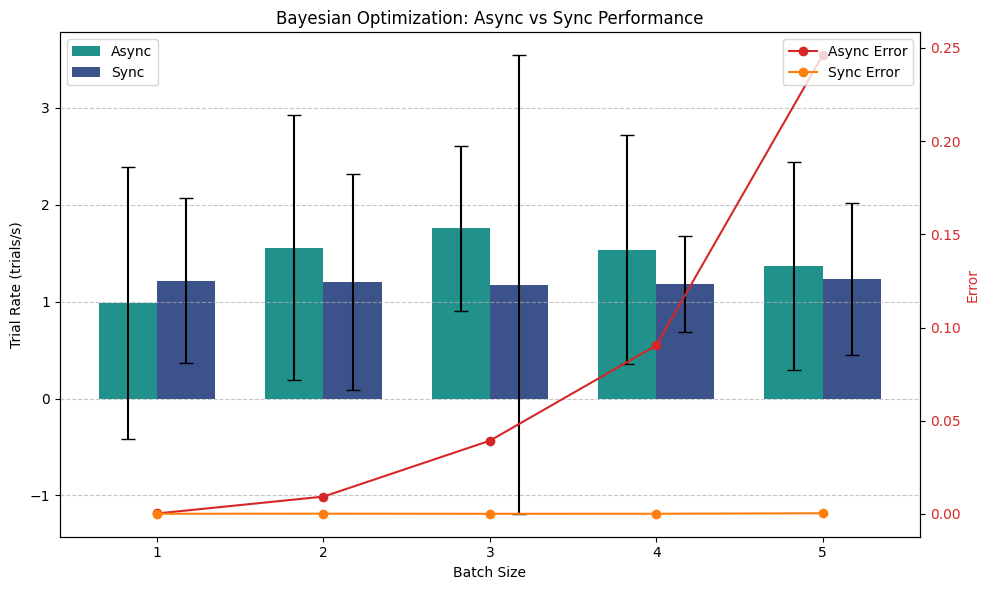

In [16]:
import time
import asyncio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

TRUE_PEAK_VALUE = 1.0  # The true peak value of the ZReader function
REPEATS = 3  # Number of times to repeat each batch size

async def run_async_experiment(batch_size, results):
    for _ in range(REPEATS):
        suggested_params = []
        observed_z = []
        best_result = {"params": None, "value": float("-inf")}

        start = time.perf_counter()
        async for params in bayesian_optimizer_iterator(
            z_reader, param_names, param_bounds,
            num_initial_samples=20, num_bo_samples=20, batch_size=batch_size, async_mode=True
        ):
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            suggested_params.append(params)
            observed_z.append(z_mean)
            if z_mean > best_result["value"]:
                best_result = {"params": params, "value": z_mean}

        end = time.perf_counter()
        elapsed_time = end - start
        error = abs(TRUE_PEAK_VALUE - best_result["value"])
        print(f"Batch size {batch_size}: Async time: {elapsed_time}, Error: {error}")

        results.append({
            "mode": "async",
            "batch_size": batch_size,
            "time": elapsed_time,
            "best_value": best_result["value"],
            "error": error
        })


async def main_async(results):
    for b_size in [1, 2, 3, 4, 5]:
        await run_async_experiment(b_size, results)


def run_sync_experiment(batch_size, results):
    for _ in range(REPEATS):
        suggested_params = []
        observed_z = []
        best_result = {"params": None, "value": float("-inf")}

        start = time.perf_counter()
        for params in bayesian_optimizer_iterator_sync(
            z_reader, param_names, param_bounds,
            num_initial_samples=20, num_bo_samples=20, batch_size=batch_size
        ):
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            suggested_params.append(params)
            observed_z.append(z_mean)
            if z_mean > best_result["value"]:
                best_result = {"params": params, "value": z_mean}

        end = time.perf_counter()
        elapsed_time = end - start
        error = abs(TRUE_PEAK_VALUE - best_result["value"])
        print(f"Batch size {batch_size}: Sync time: {elapsed_time}, Error: {error}")

        results.append({
            "mode": "sync",
            "batch_size": batch_size,
            "time": elapsed_time,
            "best_value": best_result["value"],
            "error": error
        })


def main_sync(results):
    for batch_size in [1, 2, 3, 4, 5]:
        run_sync_experiment(batch_size, results)


# Collect results
results = []
await main_async(results)
main_sync(results)

# Convert results to a pandas DataFrame
df = pd.DataFrame(results)

# Calculate mean and std for each metric
summary = df.groupby(['mode', 'batch_size']).agg(
    time_mean=('time', 'mean'),
    time_std=('time', 'std'),
    best_value_mean=('best_value', 'mean'),
    best_value_std=('best_value', 'std'),
    error_mean=('error', 'mean'),
    error_std=('error', 'std')
).reset_index()

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

# Normalize time to trial rate (trials/second)
time_data = (summary.pivot(index='batch_size', columns='mode', values='time_mean') / 20) ** -1
error_data = summary.pivot(index='batch_size', columns='mode', values='error_mean')

# Bar plot for time (primary Y-axis)
indices = np.arange(len(time_data.index))
width = 0.35
cmap = plt.get_cmap("viridis")
async_color, sync_color = cmap(0.5), cmap(0.25)

bars_async = ax1.bar(indices - width / 2, time_data['async'], width, color=async_color, label='Async')
bars_sync = ax1.bar(indices + width / 2, time_data['sync'], width, color=sync_color, label='Sync')

ax1.set_xlabel("Batch Size")
ax1.set_ylabel("Trial Rate (trials/s)", color="black")
ax1.set_title("Bayesian Optimization: Async vs Sync Performance")
ax1.set_xticks(indices)
ax1.set_xticklabels(time_data.index)
ax1.legend(loc='upper left')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Error bar for trial rate
ax1.errorbar(
    indices - width / 2, time_data['async'], 
    yerr=summary.query("mode == 'async'")["time_std"], 
    fmt="none", color="black", capsize=5
)
ax1.errorbar(
    indices + width / 2, time_data['sync'], 
    yerr=summary.query("mode == 'sync'")["time_std"], 
    fmt="none", color="black", capsize=5
)

# Line plot for error (secondary Y-axis)
ax2 = ax1.twinx()
ax2.plot(
    indices, error_data['async'], color="tab:red", marker="o", label="Async Error"
)
ax2.plot(
    indices, error_data['sync'], color="tab:orange", marker="o", label="Sync Error"
)
ax2.set_ylabel("Error", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


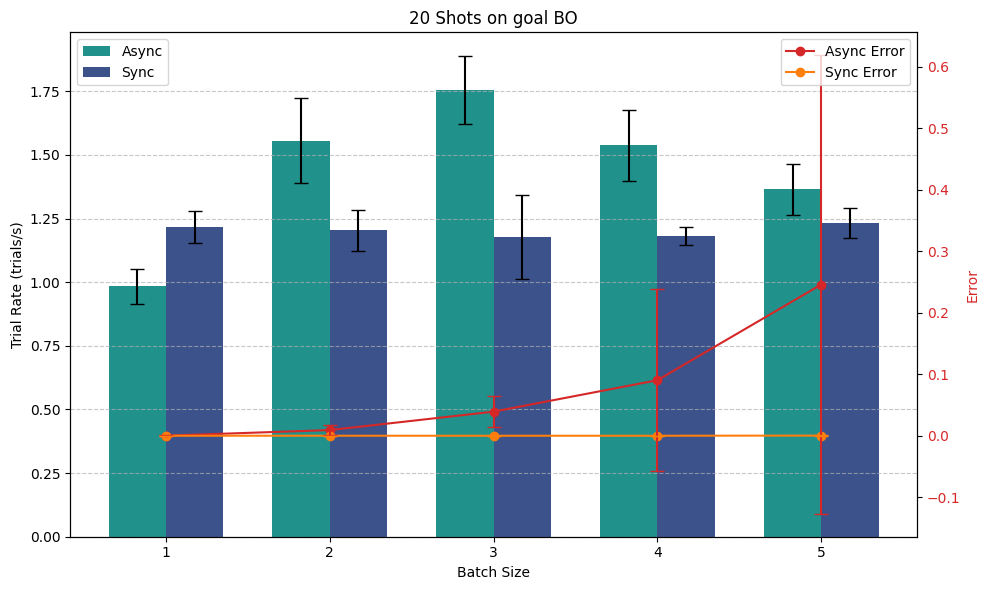

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Correctly compute trial rate mean and standard deviation
trial_rate_mean = 20 / summary.pivot(index="batch_size", columns="mode", values="time_mean")
trial_rate_std = (20 / summary.pivot(index="batch_size", columns="mode", values="time_mean") ** 2) * \
                 summary.pivot(index="batch_size", columns="mode", values="time_std")

# Clamp negative trial rate stds
trial_rate_std = np.clip(trial_rate_std, 0, None)

# Error data
error_mean = summary.pivot(index="batch_size", columns="mode", values="error_mean")
error_std = summary.pivot(index="batch_size", columns="mode", values="error_std")

# Plot time and error
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for trial rates
indices = np.arange(len(trial_rate_mean.index))
width = 0.35
cmap = plt.get_cmap("viridis")
async_color = cmap(0.5)
sync_color = cmap(0.25)

# Add bars
ax1.bar(
    indices - width / 2, trial_rate_mean["async"], width=width, color=async_color, label="Async"
)
ax1.bar(
    indices + width / 2, trial_rate_mean["sync"], width=width, color=sync_color, label="Sync"
)

# Add error bars for trial rates
ax1.errorbar(
    indices - width / 2, trial_rate_mean["async"], 
    yerr=trial_rate_std["async"], fmt="none", color="black", capsize=5
)
ax1.errorbar(
    indices + width / 2, trial_rate_mean["sync"], 
    yerr=trial_rate_std["sync"], fmt="none", color="black", capsize=5
)

# Set labels for primary y-axis
ax1.set_xlabel("Batch Size")
ax1.set_ylabel("Trial Rate (trials/s)", color="black")
ax1.set_title("20 Shots on goal BO")
ax1.set_xticks(indices)
ax1.set_xticklabels(trial_rate_mean.index)
ax1.legend(loc="upper left")
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Line plot for error (on secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(
    indices, error_mean["async"], color="tab:red", marker="o", label="Async Error"
)
ax2.plot(
    indices, error_mean["sync"], color="tab:orange", marker="o", label="Sync Error"
)

# Add error bars for error
ax2.errorbar(
    indices, error_mean["async"], 
    yerr=error_std["async"], fmt="none", color="tab:red", capsize=5
)
ax2.errorbar(
    indices, error_mean["sync"], 
    yerr=error_std["sync"], fmt="none", color="tab:orange", capsize=5
)

# Set labels for secondary y-axis
ax2.set_ylabel("Error", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.legend(loc="upper right")

# Finalize the layout
plt.tight_layout()
plt.show()
